範囲を広げて続ける

In [1]:
import re
import sys
from time import time, sleep
from pprint import pprint
from functools import partial
from multiprocessing import Pool

import numpy as np
import pandas as pd
import optuna
import matplotlib.pyplot as plt

FILENAME = "main.cpp"

In [2]:
!cp ../answer/{FILENAME} ./{FILENAME}

In [3]:
#!g++ {FILENAME} -std=gnu++17 -Wall -Wextra -O2 -DONLINE_JUDGE -o {FILENAME}.out
!g++ {FILENAME} -std=gnu++17 -Wall -Wextra -O2 -o {FILENAME}.out

main.cpp:49: warning: ignoring #pragma clang attribute [-Wunknown-pragmas]
   49 | #pragma clang attribute push (__attribute__((target("arch=skylake"))),apply_to=function)
      | 
main.cpp:1638: warning: ignoring #pragma clang attribute [-Wunknown-pragmas]
 1638 | #pragma clang attribute pop
      | 
main.cpp: In function ‘void test::TestBitBoardGetSpeed()’:
main.cpp:843:9: warning: unused variable ‘t0’ [-Wunused-variable]
  843 |  double t0;
      |         ^~
main.cpp: In function ‘void globals::UpdateValueTable()’:
main.cpp:948:15: warning: unused variable ‘vm’ [-Wunused-variable]
  948 |   const auto& vm = v_modified[idx_RCSEV];
      |               ^~
main.cpp: In member function ‘void State::RecalcFutureScore()’:
main.cpp:1046:14: warning: unused variable ‘old_subscore2’ [-Wunused-variable]
 1046 |   const auto old_subscore2 = subscore2;
      |              ^~~~~~~~~~~~~
main.cpp: In function ‘void Solve()’:
main.cpp:1445:54: warning: suggest parentheses around ‘-’ in operand 

In [4]:
# テストケース生成
SEED = 1000
N_TESTCASES = 200

# !mkdir in
# for i in range(N_TESTCASES):
#     filename = f"{i:04d}.txt"
#     seed = SEED + i
#     !python3 ../A/tester/generator.py {seed} > ./in/{filename}
# !ls in

In [5]:
TESTCASE_DIRECTORY = "./in/"
TESTCASES = [f"{i:04d}.txt" for i in range(N_TESTCASES)]

In [6]:
# もとのスコアの確認

scores = []
times = []

!mkdir out

def parallel(i):
    testcase = TESTCASES[i]
    i = f"{i:04d}"
    t0 = time()
    !./{FILENAME}.out < {TESTCASE_DIRECTORY}{testcase} > ./out/{testcase} 2> /dev/null
    t = time() - t0
    score = !python3 ../A/tester/judge.py {TESTCASE_DIRECTORY}{testcase} ./out/{testcase}
    print(i, f"time:{t:.4f}", *score)
    score = int(score[0].split(":")[-1])
    return score, t

for i in range(200):
    score, t = parallel(i)
    scores.append(score)
    times.append(t)

# with Pool(15) as p:
#     for score, t in p.map(parallel, range(N_TESTCASES)):
#         scores.append(score)
#         times.append(t)

np.mean(scores) * 50 / 1e6, np.std(scores) * 50 / 1e6

mkdir: cannot create directory ‘out’: File exists
0000 time:1.9667 score:5013695
0001 time:1.9579 score:5558535
0002 time:1.9610 score:4711238
0003 time:1.9590 score:4722296
0004 time:1.9690 score:4634671
0005 time:1.9598 score:5044800
0006 time:1.9654 score:5021352
0007 time:1.9655 score:5743890
0008 time:1.9600 score:5521076
0009 time:1.9643 score:5280321
0010 time:1.9648 score:4597303
0011 time:1.9699 score:5372221
0012 time:1.9639 score:4585629
0013 time:1.9217 score:5325078
0014 time:1.9583 score:5534581
0015 time:1.9670 score:5861749
0016 time:1.9589 score:5245705
0017 time:1.9631 score:4701137
0018 time:1.9701 score:5472650
0019 time:1.9701 score:4786674
0020 time:1.9584 score:5463651
0021 time:1.9581 score:5172628
0022 time:1.9624 score:4872741
0023 time:1.9610 score:4904047
0024 time:1.9621 score:5564740
0025 time:1.9691 score:4790937
0026 time:1.9549 score:4960300
0027 time:1.9618 score:5611477
0028 time:1.9675 score:4856389
0029 time:1.9675 score:5315431
0030 time:1.9669 sco

(256.597286, 18.321425216605125)

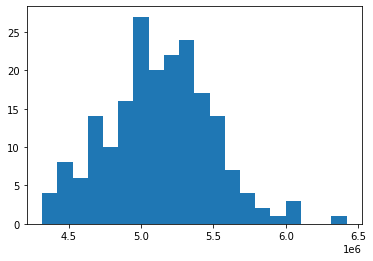

In [7]:
plt.hist(scores, bins=20)
plt.show()

In [8]:
# ここでエラー出力は何かおかしいかもしれない


# パラメータ抽出
with open(FILENAME) as f:
    answer = f.read()


variables_optimize = []

for left, value, right, options in re.findall(r"^([^/\n]*=\s*)(.+?)(\s*;\s*//(?:.*\W)?OPTIMIZE(\W.*))$", answer, re.MULTILINE):
    name = left.replace("=", "").strip().split()[-1]
    
    searched = re.search(r".*\[(?P<min>.*),(?P<max>.*)\].*", options)
    if searched:
        min_value = max_value = None
        try:
            min_value = eval(searched.group("min"))
            max_value = eval(searched.group("max"))
            assert min_value <= max_value
        except Exception as e:
            print(f"searched={searched}", file=sys.stderr)
            print(e, file=sys.stderr)
            continue
        log = "LOG" in options  # 雑、直したほうが良い
        if type(min_value) != type(max_value):
            print(f"searched={searched}", file=sys.stderr)
            print("types not matched", file=sys.stderr)
            continue
        if isinstance(min_value, int):
            method = "suggest_int"
        elif isinstance(min_value, float):
            method = "suggest_float"
        else:
            print(f"searched={searched}", file=sys.stderr)
            print(f"unknown type ({type(min_value)})", file=sys.stderr)
            continue
        variables_optimize.append({
            "name": name,
            "method": method,
            "min": min_value,
            "max": max_value,
            "log": log,
            "left": left,
            "right": right,
        })
    elif searched := re.search(r".*\{(?P<choices>.*?)\}.*", options):
        choices = list(map(lambda x: x.strip(), searched.group("choices").split(",")))
        variables_optimize.append({
            "name": name,
            "method": "suggest_categorical",
            "choices": choices,
            "left": left,
            "right": right,
        })
    else:
        print(f"searched={searched}", file=sys.stderr)
        print(f"pattern was matched but options are incorrect.", file=sys.stderr)

print(len(variables_optimize), "variables were found.")
if globals().get("pd"):
    display(pd.DataFrame(variables_optimize))
else:
    pprint(variables_optimize)

9 variables were found.


,name,method,min,max,log,left,right,choices
0,hash_table_size,suggest_int,6.000,18.000,False,constexpr int hash_table_size =,"; // OPTIMIZE [6, 18]",NaN
1,K_START,suggest_float,0.040,0.200,True,constexpr double K_START =,"; // OPTIMIZE [0.04, 0.2] LOG",NaN
2,K_END,suggest_float,0.030,0.100,True,constexpr double K_END =,"; // OPTIMIZE [0.03, 0.1] LOG",NaN
3,K_H,suggest_float,0.001,0.999,False,constexpr double K_H =,"; // OPTIMIZE [0.001, 0.999]",NaN
4,PURCHASE_TURN_LIMIT,suggest_int,790.000,870.000,False,constexpr short PURCHASE_TURN_LIMIT =,"; // OPTIMIZE [790, 870]",NaN
5,ROUGH_HASH,suggest_categorical,NaN,NaN,NaN,constexpr int ROUGH_HASH =,"; // OPTIMIZE {0, 0b00000001, 0b00010001,...","[0, 0b00000001, 0b00010001, 0b00010011, 0b0011..."
6,TARGET_BEAM_WIDTH_INCREASE_RATE,suggest_float,0.250,4.000,True,constexpr double TARGET_BEAM_WIDTH_INCREASE_RA...,"; // OPTIMIZE [0.25, 4.0] LOG",NaN
7,TARGET_BEAM_WIDTH_HALF_PROGRES_RATE,suggest_float,0.020,0.980,False,constexpr double TARGET_BEAM_WIDTH_HALF_PROGRE...,"; // OPTIMIZE [0.02, 0.98]",NaN
8,MAX_BEAM_WIDTH,suggest_int,400.000,4000.000,True,constexpr auto MAX_BEAM_WIDTH =,"; // OPTIMIZE [400, 400...",NaN


In [9]:
def escape(string):  # 正規表現の中でそのまま使いたい文字列をエスケープ
    res = !echo '{string}' | sed -e 's/[]\/$*.^[]/\\&/g'
    return res[0]

def escape_sed(string):  # sed の置換後の文字列用のエスケープ
    res = !echo '{string}' | sed -e 's/[\/&]/\\&/g'
    return res[0]


def objective_with_index(trial, n_internal_parallel):
    index_parallel = trial.number % 12  # これ変数にする
    print(f"{index_parallel=}")
    
    parameters_changed_filename = f"{index_parallel}_{FILENAME}"
    #directory_input = "./in"  # "/" をつけない  # 中のすべてのファイルに対して実行される
    
    !mkdir {index_parallel}_out 2> /dev/null
    !mkdir {index_parallel}_score 2> /dev/null
    !rm {index_parallel}_out/*
    !rm {index_parallel}_score/*
    
    # ファイル作成
    !cp {FILENAME} {parameters_changed_filename}
    sed_options = [f"-i {parameters_changed_filename}"]
    for variable in variables_optimize:
        if variable["method"] == "suggest_categorical":
            val =  trial.suggest_categorical(variable["name"], variable["choices"])
        else:
            val = getattr(trial, variable["method"])(variable["name"], variable["min"], variable["max"], log=variable["log"])
        left = variable["left"]
        right = variable["right"]
        sed_options.append(f"""-e 's/^{escape(left)}.*{escape(right)}$/{escape_sed(left)}{val}{escape_sed(right)}/'""")
    command_sed = f"sed {' '.join(sed_options)}"
    print(command_sed)
    !{command_sed}
    
    # コンパイル
    command_compile = f"g++ {parameters_changed_filename} -std=gnu++17 -O2 -DONLINE_JUDGE -o {parameters_changed_filename}.out 2> /dev/null"
    print(command_compile)
    !{command_compile}
    
    # 実行・採点コマンド (@ はファイル名)
    command_exec = (
        f"./{parameters_changed_filename}.out < {TESTCASE_DIRECTORY}@ >./{index_parallel}_out/@ 2> /dev/null;"
        f"python3 ../A/tester/judge.py {TESTCASE_DIRECTORY}@ ./{index_parallel}_out/@ > ./{index_parallel}_score/@"
        
        #f"cargo run --release --manifest-path ../tools/Cargo.toml --bin tester {directory_input}/@ $(pwd)/{parameters_changed_filename}.out 2>&1 | grep Score | sed -E s/[^0-9]+// > ./{index_parallel}_score/@;"
        
        #f"./{parameters_changed_filename}.out < {directory_input}/@ > ./{index_parallel}_out/@;"
        #f"cargo run --release --manifest-path ./tools/Cargo.toml --bin vis {directory_input}/@ ./{index_parallel}_out/@ 2> /dev/null > ./{index_parallel}_score/@;"
    )
    
    # 並列実行 (sed はパスのディレクトリ部分を消してファイル名にしてる)
    !find {TESTCASE_DIRECTORY}/* | sed 's!^.*/!!' | xargs -I@ -P {n_internal_parallel} sh -c '{command_exec}'
    
    # 集計
    file_paths = !find ./{index_parallel}_score/*
    sum_score = 0
    for file_path in file_paths:  
        with open(file_path) as f:
            sum_score += int(f.read().split(":")[-1])
    return sum_score

In [ ]:
storage_path = f"study.db"
storage = f"sqlite:///{storage_path}"
study_name = "study"
study = optuna.create_study(storage=storage, load_if_exists=True, study_name=study_name, direction="maximize")

def callback(study, trial):
    try:
        if study.best_value == trial.value:
            print(f"Updated! {study.best_value}")
            index_parallel = trial.number % 12
            parameters_changed_filename = f"{index_parallel}_{FILENAME}"
            !cp {parameters_changed_filename} 00000optimized.cpp
        print("callback ok")
    except:
        print(":(")

objective = partial(objective_with_index, n_internal_parallel=4)
study.optimize(objective, n_trials=3000, timeout=86400, n_jobs=4, callbacks=[callback])

[I 2021-09-11 04:12:21,761] Using an existing study with name 'study' instead of creating a new one.
/home/nagis/anaconda3/lib/python3.8/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(


index_parallel=2
index_parallel=1
index_parallel=0
index_parallel=3
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1940778033515955;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05709043950069253;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6168988950902877;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 

[I 2021-09-11 04:14:02,326] Trial 276 finished with value: 990575769.0 and parameters: {'hash_table_size': 8, 'K_START': 0.18223722103664747, 'K_END': 0.05699796333466742, 'K_H': 0.6170290528909378, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.7934630644742193, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3772232341499908, 'MAX_BEAM_WIDTH': 418}. Best is trial 216 with value: 1007263419.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07210219658391823;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05073518583083631;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6622763514959873;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:14:10,094] Trial 277 finished with value: 1002862684.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17993871791418595, 'K_END': 0.050557785203304804, 'K_H': 0.6193014585470334, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.806215004028236, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.422997617548877, 'MAX_BEAM_WIDTH': 629}. Best is trial 216 with value: 1007263419.0.
[I 2021-09-11 04:14:10,098] Trial 278 finished with value: 999632538.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1940778033515955, 'K_END': 0.05709043950069253, 'K_H': 0.6168988950902877, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.797720337877142, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.42156498190351627, 'MAX_BEAM_WIDTH': 626}. Best is trial 216 with value: 1007263419.0.


callback ok
callback ok
index_parallel=5
index_parallel=6


[I 2021-09-11 04:14:11,155] Trial 279 finished with value: 1004285051.0 and parameters: {'hash_table_size': 8, 'K_START': 0.19276328441770801, 'K_END': 0.05058986747811618, 'K_H': 0.6130086064884971, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.828519835479799, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.42714782775055393, 'MAX_BEAM_WIDTH': 619}. Best is trial 216 with value: 1007263419.0.


callback ok
index_parallel=7
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18196509439659395;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.050402611333047534;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.667853533116537;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:15:50,589] Trial 283 finished with value: 990721915.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17763422502819592, 'K_END': 0.050064973374685594, 'K_H': 0.5937811324043, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.808070479052709, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3880507312351412, 'MAX_BEAM_WIDTH': 602}. Best is trial 216 with value: 1007263419.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.19305018285039433;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05066196788299466;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6633649349822064;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:15:51,955] Trial 280 finished with value: 1012699148.0 and parameters: {'hash_table_size': 8, 'K_START': 0.07210219658391823, 'K_END': 0.05073518583083631, 'K_H': 0.6622763514959873, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.803315627002894, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44338622146506407, 'MAX_BEAM_WIDTH': 609}. Best is trial 280 with value: 1012699148.0.


Updated! 1012699148.0
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null
callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.19536093904302185;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05064161490162992;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6649552937378002;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00

[I 2021-09-11 04:15:57,115] Trial 281 finished with value: 1008757052.0 and parameters: {'hash_table_size': 8, 'K_START': 0.172747607641015, 'K_END': 0.0504343617566882, 'K_H': 0.6663965775926032, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.8104664015097076, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.42455781533309045, 'MAX_BEAM_WIDTH': 603}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.19431407025796654;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04919052696075346;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6644769951302761;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 04:15:58,479] Trial 282 finished with value: 1007287183.0 and parameters: {'hash_table_size': 8, 'K_START': 0.18196509439659395, 'K_END': 0.050402611333047534, 'K_H': 0.667853533116537, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.7907828295015684, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4379985834754002, 'MAX_BEAM_WIDTH': 611}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11
g++ 10_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 10_main.cpp.out 2> /dev/null
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18138356419081048;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.049282995183493467;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6967675304080684;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexp

[I 2021-09-11 04:17:31,561] Trial 287 finished with value: 1000260397.0 and parameters: {'hash_table_size': 7, 'K_START': 0.18138356419081048, 'K_END': 0.049282995183493467, 'K_H': 0.6967675304080684, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.999490458290052, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4346166112819769, 'MAX_BEAM_WIDTH': 640}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.19210755700422055;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05034348969343544;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6719924199033109;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:17:38,745] Trial 284 finished with value: 1006805371.0 and parameters: {'hash_table_size': 8, 'K_START': 0.19305018285039433, 'K_END': 0.05066196788299466, 'K_H': 0.6633649349822064, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3658845258606536, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.42963963797297133, 'MAX_BEAM_WIDTH': 634}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.19604760171338542;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04849316393390508;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6679530508939359;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:17:40,475] Trial 285 finished with value: 1007050212.0 and parameters: {'hash_table_size': 8, 'K_START': 0.19536093904302185, 'K_END': 0.05064161490162992, 'K_H': 0.6649552937378002, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3763783351520904, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43297968408439874, 'MAX_BEAM_WIDTH': 629}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.19506815166399435;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04884784642137055;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6663455014949826;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:17:43,059] Trial 286 finished with value: 1002429090.0 and parameters: {'hash_table_size': 8, 'K_START': 0.19431407025796654, 'K_END': 0.04919052696075346, 'K_H': 0.6644769951302761, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3292236939964472, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.41648971463935996, 'MAX_BEAM_WIDTH': 635}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18701156857706505;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04834887191320078;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6651740788123927;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:19:12,242] Trial 288 finished with value: 992683586.0 and parameters: {'hash_table_size': 8, 'K_START': 0.19210755700422055, 'K_END': 0.05034348969343544, 'K_H': 0.6719924199033109, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.4018555077715478, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3952343087821595, 'MAX_BEAM_WIDTH': 604}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.19951591311638314;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05362928956506476;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.666049014186809;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 04:19:20,573] Trial 290 finished with value: 997895044.0 and parameters: {'hash_table_size': 8, 'K_START': 0.19506815166399435, 'K_END': 0.04884784642137055, 'K_H': 0.6663455014949826, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.340316551017219, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3937208938556612, 'MAX_BEAM_WIDTH': 606}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18435897317293873;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.053727603723568246;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6981040788430105;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 04:19:29,312] Trial 289 finished with value: 985146299.0 and parameters: {'hash_table_size': 8, 'K_START': 0.19604760171338542, 'K_END': 0.04849316393390508, 'K_H': 0.6679530508939359, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.2538219270293321, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.42380407592232616, 'MAX_BEAM_WIDTH': 615}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1876916201112455;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05371561351666124;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7030938633383059;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 04:19:31,053] Trial 291 finished with value: 1003869174.0 and parameters: {'hash_table_size': 8, 'K_START': 0.18701156857706505, 'K_END': 0.04834887191320078, 'K_H': 0.6651740788123927, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.4152491616136826, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.418383881547399, 'MAX_BEAM_WIDTH': 599}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18697961405824826;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04595758800406931;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.696481652492041;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 04:20:59,878] Trial 292 finished with value: 1003268312.0 and parameters: {'hash_table_size': 8, 'K_START': 0.19951591311638314, 'K_END': 0.05362928956506476, 'K_H': 0.666049014186809, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.489803402569955, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4263417739637587, 'MAX_BEAM_WIDTH': 677}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8


[I 2021-09-11 04:21:00,999] Trial 295 finished with value: 992451526.0 and parameters: {'hash_table_size': 7, 'K_START': 0.18697961405824826, 'K_END': 0.04595758800406931, 'K_H': 0.696481652492041, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.482514427029068, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.36668902014948707, 'MAX_BEAM_WIDTH': 676}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18476642644354652;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05356411457161658;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7005777997589205;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:21:08,137] Trial 293 finished with value: 1004702784.0 and parameters: {'hash_table_size': 8, 'K_START': 0.18435897317293873, 'K_END': 0.053727603723568246, 'K_H': 0.6981040788430105, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.5307571082006044, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4205057307207113, 'MAX_BEAM_WIDTH': 681}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17296168831353076;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05348105292058909;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7356859091403146;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-11 04:21:16,424] Trial 294 finished with value: 1005518769.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1876916201112455, 'K_END': 0.05371561351666124, 'K_H': 0.7030938633383059, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.5522371114906854, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.42530770103172005, 'MAX_BEAM_WIDTH': 673}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18763232582968045;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05299061822720881;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7356991602464602;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 801;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 04:22:30,643] Trial 296 finished with value: 999331041.0 and parameters: {'hash_table_size': 7, 'K_START': 0.18476642644354652, 'K_END': 0.05356411457161658, 'K_H': 0.7005777997589205, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.290047864353887, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.423274036578846, 'MAX_BEAM_WIDTH': 658}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18893242750667538;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0535053032132135;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.736839347789496;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010

[I 2021-09-11 04:22:48,473] Trial 297 finished with value: 1002630835.0 and parameters: {'hash_table_size': 8, 'K_START': 0.18601558661078038, 'K_END': 0.053501944801228205, 'K_H': 0.7085687513165346, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.237200005035325, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4147331600066282, 'MAX_BEAM_WIDTH': 674}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.19006365917047824;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05403244840746219;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7285517274553045;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:22:54,808] Trial 298 finished with value: 997709710.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17296168831353076, 'K_END': 0.05348105292058909, 'K_H': 0.7356859091403146, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.179944053112718, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.41195253283940975, 'MAX_BEAM_WIDTH': 675}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2


[I 2021-09-11 04:22:55,991] Trial 299 finished with value: 977363881.0 and parameters: {'hash_table_size': 8, 'K_START': 0.18763232582968045, 'K_END': 0.05299061822720881, 'K_H': 0.7356991602464602, 'PURCHASE_TURN_LIMIT': 801, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.1687339014478773, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4088441681345333, 'MAX_BEAM_WIDTH': 658}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18893125523812943;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05262690792485636;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6999544360430267;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:24:13,941] Trial 300 finished with value: 992365346.0 and parameters: {'hash_table_size': 8, 'K_START': 0.18893242750667538, 'K_END': 0.0535053032132135, 'K_H': 0.736839347789496, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.4303034945840265, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.40933720639350496, 'MAX_BEAM_WIDTH': 678}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.19891331006990504;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04839311978329256;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6998631134862789;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:24:29,396] Trial 301 finished with value: 992442519.0 and parameters: {'hash_table_size': 8, 'K_START': 0.19006365917047824, 'K_END': 0.05403244840746219, 'K_H': 0.7285517274553045, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.500023649516964, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4031528621562749, 'MAX_BEAM_WIDTH': 692}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1996664251981463;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.047084735013013364;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6935644650374688;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:24:34,751] Trial 302 finished with value: 995239319.0 and parameters: {'hash_table_size': 8, 'K_START': 0.18893125523812943, 'K_END': 0.05262690792485636, 'K_H': 0.6999544360430267, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.481991812931326, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3747363185065291, 'MAX_BEAM_WIDTH': 579}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.19983983423998292;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0485060692925294;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6684373685298297;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 04:24:44,503] Trial 303 finished with value: 1006966125.0 and parameters: {'hash_table_size': 8, 'K_START': 0.19767129954210413, 'K_END': 0.04817241533990431, 'K_H': 0.6962501534736267, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.511151165236839, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43521612825263817, 'MAX_BEAM_WIDTH': 590}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.19997846762024896;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04625531099869259;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6746257200303484;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 04:25:53,970] Trial 304 finished with value: 995185963.0 and parameters: {'hash_table_size': 8, 'K_START': 0.19891331006990504, 'K_END': 0.04839311978329256, 'K_H': 0.6998631134862789, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.547728487112479, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.35472946818524276, 'MAX_BEAM_WIDTH': 590}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1996597343534639;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04713065544872956;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6725379953786482;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-11 04:26:13,766] Trial 305 finished with value: 990145477.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1996664251981463, 'K_END': 0.047084735013013364, 'K_H': 0.6935644650374688, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.0394608823589448, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3739646679391701, 'MAX_BEAM_WIDTH': 584}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1820112135112789;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05001817181646022;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6725495458725772;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-11 04:26:24,394] Trial 306 finished with value: 1007265559.0 and parameters: {'hash_table_size': 8, 'K_START': 0.19983983423998292, 'K_END': 0.0485060692925294, 'K_H': 0.6684373685298297, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.604955692085761, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43463809770804196, 'MAX_BEAM_WIDTH': 592}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1944487566786435;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04702662327226178;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.673244643281618;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 04:26:33,477] Trial 307 finished with value: 990989620.0 and parameters: {'hash_table_size': 8, 'K_START': 0.19997846762024896, 'K_END': 0.04625531099869259, 'K_H': 0.6746257200303484, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.5439874608525037, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4374533864434617, 'MAX_BEAM_WIDTH': 593}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.19434368816023084;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.050139361068446194;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6646310293556561;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-11 04:27:45,974] Trial 308 finished with value: 987797494.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1996597343534639, 'K_END': 0.04713065544872956, 'K_H': 0.6725379953786482, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3227303433070032, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43147206150330164, 'MAX_BEAM_WIDTH': 3290}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.19276191949390928;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05012947516352268;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6619203403951248;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:27:47,396] Trial 309 finished with value: 989842092.0 and parameters: {'hash_table_size': 7, 'K_START': 0.1820112135112789, 'K_END': 0.05001817181646022, 'K_H': 0.6725495458725772, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3610864352055567, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4322067777565126, 'MAX_BEAM_WIDTH': 643}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1933402157139069;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04878723092459357;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6630891765738306;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int 

[I 2021-09-11 04:27:57,170] Trial 310 finished with value: 989676738.0 and parameters: {'hash_table_size': 7, 'K_START': 0.1944487566786435, 'K_END': 0.04702662327226178, 'K_H': 0.673244643281618, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.523165570864092, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43350687746653144, 'MAX_BEAM_WIDTH': 648}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.19365471664807485;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.049109024597910146;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7092912430981715;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 04:28:05,717] Trial 311 finished with value: 993964700.0 and parameters: {'hash_table_size': 7, 'K_START': 0.19434368816023084, 'K_END': 0.050139361068446194, 'K_H': 0.6646310293556561, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0964847222795693, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4298485139214416, 'MAX_BEAM_WIDTH': 646}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18562602263161598;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.048335266351321994;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7073106266814909;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 04:29:36,681] Trial 312 finished with value: 1008169496.0 and parameters: {'hash_table_size': 8, 'K_START': 0.19276191949390928, 'K_END': 0.05012947516352268, 'K_H': 0.6619203403951248, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0728259118480996, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4453808849229025, 'MAX_BEAM_WIDTH': 651}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4


[I 2021-09-11 04:29:37,566] Trial 313 finished with value: 1007440865.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1933402157139069, 'K_END': 0.04878723092459357, 'K_H': 0.6630891765738306, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.1028550535764663, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4463911706549097, 'MAX_BEAM_WIDTH': 612}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17433698590655056;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04870212939828719;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7582294341350094;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:29:38,278] Trial 314 finished with value: 994347289.0 and parameters: {'hash_table_size': 8, 'K_START': 0.19365471664807485, 'K_END': 0.049109024597910146, 'K_H': 0.7092912430981715, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.185550861558002, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3942036844136743, 'MAX_BEAM_WIDTH': 617}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1848211431432865;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04817307633006074;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7025673733105503;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 04:29:56,452] Trial 315 finished with value: 1005757678.0 and parameters: {'hash_table_size': 8, 'K_START': 0.18562602263161598, 'K_END': 0.048335266351321994, 'K_H': 0.7073106266814909, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.5133302549603362, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45071408615777975, 'MAX_BEAM_WIDTH': 609}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17346133816076312;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04527038219633381;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7153263350987218;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:31:27,112] Trial 316 finished with value: 1009370364.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17433698590655056, 'K_END': 0.04870212939828719, 'K_H': 0.7582294341350094, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0867216476043153, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.450829419075079, 'MAX_BEAM_WIDTH': 608}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8


[I 2021-09-11 04:31:27,371] Trial 317 finished with value: 1008761620.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1848211431432865, 'K_END': 0.04817307633006074, 'K_H': 0.7025673733105503, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.1099934303568713, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44853282386467735, 'MAX_BEAM_WIDTH': 596}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9


[I 2021-09-11 04:31:28,344] Trial 318 finished with value: 1006987903.0 and parameters: {'hash_table_size': 8, 'K_START': 0.18295311477397044, 'K_END': 0.04817706055370759, 'K_H': 0.6922083416669014, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0810874762627436, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4544864646865853, 'MAX_BEAM_WIDTH': 594}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17148505173715814;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04815717100750574;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7535405729080268;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 04:31:47,694] Trial 319 finished with value: 1009690169.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17346133816076312, 'K_END': 0.04527038219633381, 'K_H': 0.7153263350987218, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.132431228181635, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45098717016975487, 'MAX_BEAM_WIDTH': 590}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16292159376474416;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04526829779500882;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7604541030976357;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 04:33:17,492] Trial 320 finished with value: 1007657998.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17148505173715814, 'K_END': 0.04815717100750574, 'K_H': 0.7535405729080268, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.907761273733478, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45280940357326066, 'MAX_BEAM_WIDTH': 583}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0


[I 2021-09-11 04:33:17,704] Trial 321 finished with value: 1006987809.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17415230890037006, 'K_END': 0.0459000627910285, 'K_H': 0.7654707053854732, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.1423138581409056, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45028810278076337, 'MAX_BEAM_WIDTH': 575}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1


[I 2021-09-11 04:33:18,343] Trial 322 finished with value: 1007370932.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16244695928959446, 'K_END': 0.04779969436507075, 'K_H': 0.7719865718403542, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.946090095088489, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4509938758485965, 'MAX_BEAM_WIDTH': 576}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1629857626544588;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04473166511850319;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7701006703571139;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 04:33:38,307] Trial 323 finished with value: 1009810549.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16292159376474416, 'K_END': 0.04526829779500882, 'K_H': 0.7604541030976357, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.08502370159995, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4519479420582272, 'MAX_BEAM_WIDTH': 575}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16250797036270484;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04404983947489564;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7619371656800479;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:35:07,887] Trial 325 finished with value: 1007997077.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1614897833933635, 'K_END': 0.0448474364462424, 'K_H': 0.7691518548017403, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.03439334440902, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4524912860318968, 'MAX_BEAM_WIDTH': 401}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4


[I 2021-09-11 04:35:08,164] Trial 324 finished with value: 1006188550.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1629857626544588, 'K_END': 0.04473166511850319, 'K_H': 0.7701006703571139, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.904828979525253, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45373182763522485, 'MAX_BEAM_WIDTH': 573}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5


[I 2021-09-11 04:35:08,379] Trial 326 finished with value: 1005205708.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16301176446884943, 'K_END': 0.044543049782041634, 'K_H': 0.8089051476785589, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.898090816065672, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44789531446783387, 'MAX_BEAM_WIDTH': 570}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1595059054580412;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04526465791090192;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.768985776674059;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00

[I 2021-09-11 04:35:28,472] Trial 327 finished with value: 1007938197.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16250797036270484, 'K_END': 0.04404983947489564, 'K_H': 0.7619371656800479, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.920981026640184, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45057571597811297, 'MAX_BEAM_WIDTH': 565}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16637433297986703;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04524818483543392;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7676166973446438;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:36:58,233] Trial 328 finished with value: 1006007478.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1595059054580412, 'K_END': 0.04526465791090192, 'K_H': 0.768985776674059, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.760113494973974, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4535958406148507, 'MAX_BEAM_WIDTH': 400}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8


[I 2021-09-11 04:36:59,259] Trial 330 finished with value: 1009227632.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16142947149301395, 'K_END': 0.04480137630340743, 'K_H': 0.7720778154975806, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.784327019227336, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45007475275785014, 'MAX_BEAM_WIDTH': 414}. Best is trial 280 with value: 1012699148.0.
[I 2021-09-11 04:36:59,271] Trial 329 finished with value: 1008632128.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16160368431894098, 'K_END': 0.04554662787562805, 'K_H': 0.7603898953084894, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9073584926466367, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45261840883578386, 'MAX_BEAM_WIDTH': 576}. Best is trial 280 with value: 1012699148.0.


callback ok
callback ok
index_parallel=9
index_parallel=10
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16033336584389069;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04526014666920451;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7666650882925962;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b000000

[I 2021-09-11 04:37:19,500] Trial 331 finished with value: 1008416459.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16637433297986703, 'K_END': 0.04524818483543392, 'K_H': 0.7676166973446438, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8085645495049283, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4517154675999195, 'MAX_BEAM_WIDTH': 409}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16554607764409277;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.044151764007516844;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7651974209144421;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-11 04:38:49,292] Trial 332 finished with value: 1009667752.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16033336584389069, 'K_END': 0.04526014666920451, 'K_H': 0.7666650882925962, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.754927091013929, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45850483517431895, 'MAX_BEAM_WIDTH': 413}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0


[I 2021-09-11 04:38:49,779] Trial 333 finished with value: 1008952638.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15800586683486986, 'K_END': 0.04433499773768521, 'K_H': 0.7658048100328863, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.715340377575732, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44958146322479936, 'MAX_BEAM_WIDTH': 563}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1


[I 2021-09-11 04:38:49,921] Trial 334 finished with value: 1008442107.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16012239945376686, 'K_END': 0.04515322163356259, 'K_H': 0.7620846497119736, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.845908405162953, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4517621692339118, 'MAX_BEAM_WIDTH': 417}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15456930737004765;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04553257369760229;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8035430887614632;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:38:52,554] Trial 335 finished with value: 1003989147.0 and parameters: {'hash_table_size': 7, 'K_START': 0.16554607764409277, 'K_END': 0.044151764007516844, 'K_H': 0.7651974209144421, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8919559091252665, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45378370320281525, 'MAX_BEAM_WIDTH': 418}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15460200557920573;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04537906890747178;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8027998171734047;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 04:40:22,801] Trial 337 finished with value: 987039262.0 and parameters: {'hash_table_size': 7, 'K_START': 0.15541831017212798, 'K_END': 0.045722642301718526, 'K_H': 0.8016301843628669, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7037762840608925, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45051051858279845, 'MAX_BEAM_WIDTH': 417}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4


[I 2021-09-11 04:40:23,040] Trial 336 finished with value: 999016992.0 and parameters: {'hash_table_size': 7, 'K_START': 0.15456930737004765, 'K_END': 0.04553257369760229, 'K_H': 0.8035430887614632, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.722874613239169, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4523971442757893, 'MAX_BEAM_WIDTH': 423}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5


[I 2021-09-11 04:40:24,063] Trial 338 finished with value: 1001417629.0 and parameters: {'hash_table_size': 7, 'K_START': 0.14644442578509445, 'K_END': 0.044214279284759385, 'K_H': 0.8163041705451168, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7746611641130734, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45343537718142685, 'MAX_BEAM_WIDTH': 411}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16962198671023693;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0438601888207235;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.833830082910329;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00

[I 2021-09-11 04:40:43,623] Trial 339 finished with value: 988797365.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15460200557920573, 'K_END': 0.04537906890747178, 'K_H': 0.8027998171734047, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.677090027579746, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45226927086270013, 'MAX_BEAM_WIDTH': 560}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16899038894941631;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04352395678558728;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7501190357572908;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:42:12,999] Trial 340 finished with value: 1006221950.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16962198671023693, 'K_END': 0.0438601888207235, 'K_H': 0.833830082910329, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.016140861415798, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4451595710647331, 'MAX_BEAM_WIDTH': 404}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8


[I 2021-09-11 04:42:13,640] Trial 341 finished with value: 1005650946.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14535124076318498, 'K_END': 0.043833133164071204, 'K_H': 0.7535235046363505, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9727134952059013, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4644362605940819, 'MAX_BEAM_WIDTH': 407}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9


[I 2021-09-11 04:42:13,784] Trial 342 finished with value: 1004828178.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15960216542282527, 'K_END': 0.04354236038104441, 'K_H': 0.7593630925226902, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.993972016073612, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44236445077631564, 'MAX_BEAM_WIDTH': 404}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17230792905196968;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.046383893789422224;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7814117744432696;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 04:42:35,341] Trial 343 finished with value: 1006039354.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16899038894941631, 'K_END': 0.04352395678558728, 'K_H': 0.7501190357572908, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.901650996955117, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4643052579575727, 'MAX_BEAM_WIDTH': 420}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17244867502402753;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.046467769552081525;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7874542135096251;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-11 04:43:53,782] Trial 344 finished with value: 990720922.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17230792905196968, 'K_END': 0.046383893789422224, 'K_H': 0.7814117744432696, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8259288254135533, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.39936708432259876, 'MAX_BEAM_WIDTH': 425}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0


[I 2021-09-11 04:43:54,772] Trial 346 finished with value: 991771682.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1732914143675118, 'K_END': 0.0466817816493963, 'K_H': 0.7861223212621843, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8929453720817304, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4003535825925949, 'MAX_BEAM_WIDTH': 432}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16249811803593114;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.046223812199520584;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7707249347896689;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 04:44:04,891] Trial 345 finished with value: 1008722748.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17157249440265354, 'K_END': 0.046168005474414055, 'K_H': 0.7828167241190347, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8368445697451836, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46612132285155683, 'MAX_BEAM_WIDTH': 424}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1630027661821579;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.045251567242954135;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7634879999739425;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:44:16,513] Trial 347 finished with value: 992928310.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17244867502402753, 'K_END': 0.046467769552081525, 'K_H': 0.7874542135096251, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8276880130191095, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3956918368467807, 'MAX_BEAM_WIDTH': 577}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16279013160685085;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.045171433940056925;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7518290054047241;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 04:45:45,183] Trial 348 finished with value: 1005095293.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16249811803593114, 'K_END': 0.046223812199520584, 'K_H': 0.7707249347896689, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.06179312391557, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44019160904868815, 'MAX_BEAM_WIDTH': 2444}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4


[I 2021-09-11 04:45:45,761] Trial 349 finished with value: 1005646281.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16325492076058742, 'K_END': 0.041903648518821925, 'K_H': 0.7733131098049277, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0687704829174502, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43933580197810296, 'MAX_BEAM_WIDTH': 573}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1656874726859588;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04482626982261501;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7563429717599061;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 856;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 04:45:56,192] Trial 350 finished with value: 1008517421.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1630027661821579, 'K_END': 0.045251567242954135, 'K_H': 0.7634879999739425, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0495997481011217, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4664346645840658, 'MAX_BEAM_WIDTH': 438}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.158578267025015;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.045001041510567066;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7494675069505389;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 04:46:08,007] Trial 351 finished with value: 1006834698.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16279013160685085, 'K_END': 0.045171433940056925, 'K_H': 0.7518290054047241, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0258213562455616, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46801419447835135, 'MAX_BEAM_WIDTH': 440}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1486305237817244;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.044426853147357774;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7365684007267176;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:46:41,664] Trial 353 finished with value: 976453545.0 and parameters: {'hash_table_size': 6, 'K_START': 0.16752612417519996, 'K_END': 0.04505012527871653, 'K_H': 0.7495151052064066, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.732256891116712, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46717489943530344, 'MAX_BEAM_WIDTH': 440}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15872781066510086;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04735562654014976;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7334486873416881;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 854;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 04:47:37,266] Trial 352 finished with value: 997410086.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1656874726859588, 'K_END': 0.04482626982261501, 'K_H': 0.7563429717599061, 'PURCHASE_TURN_LIMIT': 856, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.708197563899957, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46729667037174066, 'MAX_BEAM_WIDTH': 438}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15605379902950828;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.047311750523663085;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7881753021375926;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 04:47:48,126] Trial 354 finished with value: 1007366303.0 and parameters: {'hash_table_size': 8, 'K_START': 0.158578267025015, 'K_END': 0.045001041510567066, 'K_H': 0.7494675069505389, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.678194238704715, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4666807714344327, 'MAX_BEAM_WIDTH': 442}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1577732281971245;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04212606285735435;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7943947529338071;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 04:48:00,165] Trial 355 finished with value: 1007568143.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1486305237817244, 'K_END': 0.044426853147357774, 'K_H': 0.7365684007267176, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.578660365664, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4705955738017808, 'MAX_BEAM_WIDTH': 449}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15045608608058403;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04429645676078794;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7400478573860724;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-11 04:48:33,355] Trial 356 finished with value: 997387997.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15872781066510086, 'K_END': 0.04735562654014976, 'K_H': 0.7334486873416881, 'PURCHASE_TURN_LIMIT': 854, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.621628038758316, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46830180774448393, 'MAX_BEAM_WIDTH': 401}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1489526063571979;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.043030792585099474;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7944193483474887;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:49:25,066] Trial 358 finished with value: 993332795.0 and parameters: {'hash_table_size': 7, 'K_START': 0.1577732281971245, 'K_END': 0.04212606285735435, 'K_H': 0.7943947529338071, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6381769223887104, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4676297617347217, 'MAX_BEAM_WIDTH': 401}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15359515137826654;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04291280274845868;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7424741549555046;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:49:28,836] Trial 357 finished with value: 1003311731.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15605379902950828, 'K_END': 0.047311750523663085, 'K_H': 0.7881753021375926, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6162996018318583, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4677122515071339, 'MAX_BEAM_WIDTH': 403}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1500200035970668;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.042932806995428015;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.744659913076652;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 04:49:34,315] Trial 359 finished with value: 994839804.0 and parameters: {'hash_table_size': 7, 'K_START': 0.15045608608058403, 'K_END': 0.04429645676078794, 'K_H': 0.7400478573860724, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.584098469431085, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4750414014089268, 'MAX_BEAM_WIDTH': 455}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14802602223733805;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04295794684547693;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8192068790651281;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:50:07,136] Trial 360 finished with value: 1001119921.0 and parameters: {'hash_table_size': 7, 'K_START': 0.1489526063571979, 'K_END': 0.043030792585099474, 'K_H': 0.7944193483474887, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8188242837635547, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4717464913855287, 'MAX_BEAM_WIDTH': 432}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16051073187669354;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0454892547719356;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8263434506051308;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 04:51:15,229] Trial 361 finished with value: 1007417753.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15359515137826654, 'K_END': 0.04291280274845868, 'K_H': 0.7424741549555046, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8012004524989162, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46904915979054884, 'MAX_BEAM_WIDTH': 456}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1605337182925995;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04051816415509576;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7362132251222897;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 04:51:18,944] Trial 362 finished with value: 1006150251.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1500200035970668, 'K_END': 0.042932806995428015, 'K_H': 0.744659913076652, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.824895328172005, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.443615436360734, 'MAX_BEAM_WIDTH': 457}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1602430034030425;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04549672422460077;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8424532944981222;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 04:51:22,707] Trial 363 finished with value: 1000397854.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14802602223733805, 'K_END': 0.04295794684547693, 'K_H': 0.8192068790651281, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8300284020635282, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.41590618111559086, 'MAX_BEAM_WIDTH': 427}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16024845108245664;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04099761138526049;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7701279165203845;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:51:57,156] Trial 364 finished with value: 1007664377.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16051073187669354, 'K_END': 0.0454892547719356, 'K_H': 0.8263434506051308, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8786550110954527, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4421345217188315, 'MAX_BEAM_WIDTH': 434}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16099835603888116;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04040616985702437;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7709238548447348;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:53:05,026] Trial 365 finished with value: 1005654361.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1605337182925995, 'K_END': 0.04051816415509576, 'K_H': 0.7362132251222897, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8648652816630364, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43911131529392583, 'MAX_BEAM_WIDTH': 469}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16548064884937658;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04489174929805185;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8843770156760111;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:53:07,101] Trial 366 finished with value: 1000657207.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1602430034030425, 'K_END': 0.04549672422460077, 'K_H': 0.8424532944981222, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4543070376036122, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4124375467799081, 'MAX_BEAM_WIDTH': 433}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16610702013040507;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.041333617881777765;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7718631366403511;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-11 04:53:12,296] Trial 367 finished with value: 1003309192.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16024845108245664, 'K_END': 0.04099761138526049, 'K_H': 0.7701279165203845, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9307246359660386, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4394332412982453, 'MAX_BEAM_WIDTH': 465}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16730483988646527;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04457431230689334;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.865865848362327;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 04:53:48,251] Trial 368 finished with value: 1005706488.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16099835603888116, 'K_END': 0.04040616985702437, 'K_H': 0.7709238548447348, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4675804786820024, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45640345749868716, 'MAX_BEAM_WIDTH': 486}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14123972315902072;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04478465741648367;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8581037965756229;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:54:52,674] Trial 369 finished with value: 999509565.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16548064884937658, 'K_END': 0.04489174929805185, 'K_H': 0.8843770156760111, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.47950927981829, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4161716698730829, 'MAX_BEAM_WIDTH': 445}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15401581610126364;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04420085690078884;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7257531489654199;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:54:57,696] Trial 370 finished with value: 1006614313.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16610702013040507, 'K_END': 0.041333617881777765, 'K_H': 0.7718631366403511, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.968846437345049, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4568009120404714, 'MAX_BEAM_WIDTH': 473}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15406597049075538;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04427803763105004;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7256166949862323;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:55:04,165] Trial 371 finished with value: 1003454455.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16730483988646527, 'K_END': 0.04457431230689334, 'K_H': 0.865865848362327, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5929313255306807, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4576814125586313, 'MAX_BEAM_WIDTH': 443}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15242971558195703;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04605017453168632;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8295119531839509;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:55:38,691] Trial 372 finished with value: 1007711457.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14123972315902072, 'K_END': 0.04478465741648367, 'K_H': 0.8581037965756229, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.690183489846135, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46192609440216004, 'MAX_BEAM_WIDTH': 444}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1547413082017976;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.045958572157889524;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8215273418440335;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:56:43,649] Trial 373 finished with value: 1009062497.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15401581610126364, 'K_END': 0.04420085690078884, 'K_H': 0.7257531489654199, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7123605951379894, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4586709138333545, 'MAX_BEAM_WIDTH': 425}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14149350089045484;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0438884189554446;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8171415783551891;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 04:56:48,880] Trial 374 finished with value: 1008876640.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15406597049075538, 'K_END': 0.04427803763105004, 'K_H': 0.7256166949862323, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.681863323713364, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.47656092407546424, 'MAX_BEAM_WIDTH': 422}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1438568252343356;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04250228395478895;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8530607826979286;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 04:56:55,356] Trial 375 finished with value: 1009272313.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15242971558195703, 'K_END': 0.04605017453168632, 'K_H': 0.8295119531839509, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7313760988591063, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4714282186460774, 'MAX_BEAM_WIDTH': 432}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15282167065857047;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04605588068015164;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8440240801127973;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:57:18,006] Trial 376 finished with value: 994634089.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1547413082017976, 'K_END': 0.045958572157889524, 'K_H': 0.8215273418440335, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7403113293882977, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.16441364637043365, 'MAX_BEAM_WIDTH': 422}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15015691360877748;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0440133995203456;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8646779708592219;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 04:58:12,328] Trial 377 finished with value: 984952383.0 and parameters: {'hash_table_size': 7, 'K_START': 0.14149350089045484, 'K_END': 0.0438884189554446, 'K_H': 0.8171415783551891, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7522677557399335, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.07621665095260005, 'MAX_BEAM_WIDTH': 423}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14466953863288323;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04633274447978925;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8560308894663325;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 04:58:22,642] Trial 378 finished with value: 996152859.0 and parameters: {'hash_table_size': 7, 'K_START': 0.1438568252343356, 'K_END': 0.04250228395478895, 'K_H': 0.8530607826979286, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.746008284011606, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.47512912841418714, 'MAX_BEAM_WIDTH': 425}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15284681738064457;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04628581916982734;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7277513365609047;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 04:58:28,413] Trial 379 finished with value: 1000997984.0 and parameters: {'hash_table_size': 7, 'K_START': 0.15282167065857047, 'K_END': 0.04605588068015164, 'K_H': 0.8440240801127973, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.71519945113306, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.47966624447500467, 'MAX_BEAM_WIDTH': 423}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17410275520109483;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04456923136102279;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8905665710923425;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 04:58:51,153] Trial 380 finished with value: 996987552.0 and parameters: {'hash_table_size': 7, 'K_START': 0.15015691360877748, 'K_END': 0.0440133995203456, 'K_H': 0.8646779708592219, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5744547574387893, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4767235937117533, 'MAX_BEAM_WIDTH': 421}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17267258136359898;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0467773118665404;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7293663242671848;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 05:00:03,444] Trial 381 finished with value: 1006705810.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14466953863288323, 'K_END': 0.04633274447978925, 'K_H': 0.8560308894663325, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5773557201431303, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.47290110773865696, 'MAX_BEAM_WIDTH': 420}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1374249685277977;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.044400515666812725;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7241268050299944;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:00:13,278] Trial 382 finished with value: 1008429380.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15284681738064457, 'K_END': 0.04628581916982734, 'K_H': 0.7277513365609047, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0350402177610785, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.47769013290153484, 'MAX_BEAM_WIDTH': 419}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17270103854723157;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.044840551316385806;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7236855625568602;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 05:00:16,298] Trial 383 finished with value: 1001931185.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17410275520109483, 'K_END': 0.04456923136102279, 'K_H': 0.8905665710923425, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5417354402662085, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4226071092686371, 'MAX_BEAM_WIDTH': 400}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.169921535017218;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.045487735716883276;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9040929425663865;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 05:00:39,715] Trial 384 finished with value: 1005982016.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17267258136359898, 'K_END': 0.0467773118665404, 'K_H': 0.7293663242671848, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.05098804004849, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4290164059672715, 'MAX_BEAM_WIDTH': 410}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15510290215993436;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04512809648177473;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9231689026059711;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:01:52,051] Trial 385 finished with value: 1004863717.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1374249685277977, 'K_END': 0.044400515666812725, 'K_H': 0.7241268050299944, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0606452375093833, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4229416911804291, 'MAX_BEAM_WIDTH': 402}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15228315849057614;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04592462818233572;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7242044704085869;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 05:02:01,100] Trial 386 finished with value: 1005267899.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17270103854723157, 'K_END': 0.044840551316385806, 'K_H': 0.7236855625568602, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9967057505055785, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4237148426239471, 'MAX_BEAM_WIDTH': 400}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.155012882697892;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.046015867550267785;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7925702413641615;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 05:02:05,315] Trial 387 finished with value: 1001772994.0 and parameters: {'hash_table_size': 8, 'K_START': 0.169921535017218, 'K_END': 0.045487735716883276, 'K_H': 0.9040929425663865, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9837683467968974, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4367707195799526, 'MAX_BEAM_WIDTH': 445}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15366281613683602;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.043534991045035366;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7958637737754175;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 05:02:30,529] Trial 388 finished with value: 1006319464.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15510290215993436, 'K_END': 0.04512809648177473, 'K_H': 0.9231689026059711, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.921477207804708, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4527557703012468, 'MAX_BEAM_WIDTH': 456}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15303501363962593;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04356437650320175;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7887107747123924;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 05:03:42,428] Trial 389 finished with value: 992316405.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15228315849057614, 'K_END': 0.04592462818233572, 'K_H': 0.7242044704085869, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.36107845272455, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4534734558398871, 'MAX_BEAM_WIDTH': 443}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16511182065292984;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.043590437749194244;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7882435492934183;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 05:03:51,881] Trial 390 finished with value: 1008396432.0 and parameters: {'hash_table_size': 8, 'K_START': 0.155012882697892, 'K_END': 0.046015867550267785, 'K_H': 0.7925702413641615, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.874563862712716, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4534292049291563, 'MAX_BEAM_WIDTH': 447}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1652921226146395;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0468784791303137;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8021608314582174;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:03:56,754] Trial 391 finished with value: 1006056904.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15366281613683602, 'K_END': 0.043534991045035366, 'K_H': 0.7958637737754175, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8610103198289814, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45408382979209183, 'MAX_BEAM_WIDTH': 466}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16511933581676233;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04698265693009249;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8318027798646267;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 05:04:21,203] Trial 392 finished with value: 990672802.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15303501363962593, 'K_END': 0.04356437650320175, 'K_H': 0.7887107747123924, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8384868446550073, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4733073536266096, 'MAX_BEAM_WIDTH': 440}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1669848370750669;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.046911956709295835;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8293985481886912;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:05:33,192] Trial 394 finished with value: 992577562.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1652921226146395, 'K_END': 0.0468784791303137, 'K_H': 0.8021608314582174, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8056962409628836, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3892117998396173, 'MAX_BEAM_WIDTH': 483}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1


[I 2021-09-11 05:05:33,929] Trial 393 finished with value: 1008727992.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16511182065292984, 'K_END': 0.043590437749194244, 'K_H': 0.7882435492934183, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.848275594794928, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.47797152005638915, 'MAX_BEAM_WIDTH': 477}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16355090247514145;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04215304955112277;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8243417158619284;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:05:45,936] Trial 395 finished with value: 981994356.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16511933581676233, 'K_END': 0.04698265693009249, 'K_H': 0.8318027798646267, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.34482335946156933, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.38484319229106834, 'MAX_BEAM_WIDTH': 490}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15799771834182658;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0913424626944657;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8138036375294129;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 05:06:01,536] Trial 396 finished with value: 992206711.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1669848370750669, 'K_END': 0.046911956709295835, 'K_H': 0.8293985481886912, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.1616611335308877, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.40132734313195584, 'MAX_BEAM_WIDTH': 479}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1587834050595153;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04252157628830491;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.777115253548724;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00

[I 2021-09-11 05:07:13,151] Trial 397 finished with value: 989922351.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16355090247514145, 'K_END': 0.04215304955112277, 'K_H': 0.8243417158619284, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.1558108102287594, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.40697175496614707, 'MAX_BEAM_WIDTH': 420}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15772456089179465;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04583928784522042;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7860844873750481;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:07:20,676] Trial 398 finished with value: 997186477.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1588777643419417, 'K_END': 0.042410939269678434, 'K_H': 0.8265263935281497, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6624274201534344, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.411758139357891, 'MAX_BEAM_WIDTH': 429}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15654098297809976;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04576484227773216;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7838582688166246;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:07:32,860] Trial 400 finished with value: 997810441.0 and parameters: {'hash_table_size': 7, 'K_START': 0.1587834050595153, 'K_END': 0.04252157628830491, 'K_H': 0.777115253548724, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.1097637225187222, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4797580120704356, 'MAX_BEAM_WIDTH': 430}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15689887295197308;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04580739651463692;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7579940247992365;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:07:36,177] Trial 399 finished with value: 996345746.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15799771834182658, 'K_END': 0.0913424626944657, 'K_H': 0.8138036375294129, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.155020074097801, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48017160601021386, 'MAX_BEAM_WIDTH': 428}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14028949741828112;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04562755815057155;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.75589124684768;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00

[I 2021-09-11 05:08:46,184] Trial 401 finished with value: 1000168427.0 and parameters: {'hash_table_size': 7, 'K_START': 0.15772456089179465, 'K_END': 0.04583928784522042, 'K_H': 0.7860844873750481, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.686007428281967, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4846769257957457, 'MAX_BEAM_WIDTH': 432}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1770587037224921;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04394476988951014;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.75865474110403;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b001

[I 2021-09-11 05:08:53,797] Trial 402 finished with value: 1001197212.0 and parameters: {'hash_table_size': 7, 'K_START': 0.15654098297809976, 'K_END': 0.04576484227773216, 'K_H': 0.7838582688166246, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.97495036378171, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4760697651765217, 'MAX_BEAM_WIDTH': 434}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16859350783846183;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04398202594486932;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7575260595608626;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 05:09:23,463] Trial 403 finished with value: 1003816037.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15689887295197308, 'K_END': 0.04580739651463692, 'K_H': 0.7579940247992365, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.432130846998522, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44103951372338274, 'MAX_BEAM_WIDTH': 457}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17781726973899636;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04396455426598814;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7590911079509303;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-11 05:09:25,814] Trial 404 finished with value: 1005809310.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14028949741828112, 'K_END': 0.04562755815057155, 'K_H': 0.75589124684768, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.426057448924793, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43582864935387655, 'MAX_BEAM_WIDTH': 455}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1780136447435036;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04380116470751225;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.807518931816358;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00

[I 2021-09-11 05:10:36,420] Trial 405 finished with value: 1006884283.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1770587037224921, 'K_END': 0.04394476988951014, 'K_H': 0.75865474110403, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4122507791302805, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43957509785579, 'MAX_BEAM_WIDTH': 459}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16837248499458426;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04373669539770236;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7896694487132513;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 809;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:10:43,368] Trial 406 finished with value: 1006520322.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16859350783846183, 'K_END': 0.04398202594486932, 'K_H': 0.7575260595608626, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4881075370380334, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43954355902560543, 'MAX_BEAM_WIDTH': 458}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14741468749898864;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04481652512098779;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7988479327021294;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 05:11:13,059] Trial 407 finished with value: 997142319.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17781726973899636, 'K_END': 0.04396455426598814, 'K_H': 0.7590911079509303, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.702014839602799, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4390185966174138, 'MAX_BEAM_WIDTH': 415}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1493989026376331;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.045032835141878655;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8012823685229187;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:11:16,634] Trial 408 finished with value: 1005352387.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1780136447435036, 'K_END': 0.04380116470751225, 'K_H': 0.807518931816358, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.793527970031946, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4585774952917834, 'MAX_BEAM_WIDTH': 402}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1633615166750493;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04495760918721861;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7780962456652548;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 790;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 05:12:26,032] Trial 409 finished with value: 994116470.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16837248499458426, 'K_END': 0.04373669539770236, 'K_H': 0.7896694487132513, 'PURCHASE_TURN_LIMIT': 809, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.730219081997078, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4609987231703889, 'MAX_BEAM_WIDTH': 417}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14608427883728278;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04686855661189445;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7307928319258583;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:12:34,627] Trial 410 finished with value: 996038265.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14741468749898864, 'K_END': 0.04481652512098779, 'K_H': 0.7988479327021294, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.766380828418826, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46064208525380246, 'MAX_BEAM_WIDTH': 420}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16364659252615668;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04712600580961315;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7281010014687889;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:13:03,403] Trial 411 finished with value: 1008842487.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1493989026376331, 'K_END': 0.045032835141878655, 'K_H': 0.8012823685229187, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.857054894756886, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45698610101076176, 'MAX_BEAM_WIDTH': 400}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04287690020613508;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04690389999697086;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7236112290782682;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 790;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:13:04,982] Trial 412 finished with value: 973789102.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1633615166750493, 'K_END': 0.04495760918721861, 'K_H': 0.7780962456652548, 'PURCHASE_TURN_LIMIT': 790, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9611731247889037, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46070265412598543, 'MAX_BEAM_WIDTH': 530}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1495726506605466;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04690790558968899;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.723889185915441;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00

[I 2021-09-11 05:14:11,800] Trial 413 finished with value: 1002862576.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14608427883728278, 'K_END': 0.04686855661189445, 'K_H': 0.7307928319258583, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9159590742645993, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5097518641354114, 'MAX_BEAM_WIDTH': 536}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15063786603524085;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04695732303111004;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7215205093242018;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:14:21,637] Trial 414 finished with value: 987704158.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16364659252615668, 'K_END': 0.04712600580961315, 'K_H': 0.7281010014687889, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7457136310030826, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.511977686888775, 'MAX_BEAM_WIDTH': 531}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15098972483253867;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04185929111742321;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7456888494782867;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 05:14:37,689] Trial 415 finished with value: 956899508.0 and parameters: {'hash_table_size': 8, 'K_START': 0.04287690020613508, 'K_END': 0.04690389999697086, 'K_H': 0.7236112290782682, 'PURCHASE_TURN_LIMIT': 790, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.014773707020946, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.03335865457198195, 'MAX_BEAM_WIDTH': 534}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11


[I 2021-09-11 05:14:37,950] Trial 416 finished with value: 1003598230.0 and parameters: {'hash_table_size': 7, 'K_START': 0.1495726506605466, 'K_END': 0.04690790558968899, 'K_H': 0.723889185915441, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0440067011287204, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5165893774805634, 'MAX_BEAM_WIDTH': 404}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15163649534182455;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.042598509127203504;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7736043776490438;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 05:15:43,624] Trial 417 finished with value: 1006455679.0 and parameters: {'hash_table_size': 7, 'K_START': 0.15063786603524085, 'K_END': 0.04695732303111004, 'K_H': 0.7215205093242018, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.062291669210324, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48429026285050947, 'MAX_BEAM_WIDTH': 402}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1516782879861503;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.041805044762258915;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7767192059978746;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:15:54,834] Trial 418 finished with value: 1001033976.0 and parameters: {'hash_table_size': 7, 'K_START': 0.15098972483253867, 'K_END': 0.04185929111742321, 'K_H': 0.7456888494782867, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.084375406940016, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4823624724258767, 'MAX_BEAM_WIDTH': 401}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17161034197744093;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.043192300621208594;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7785306819662328;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 05:16:28,656] Trial 419 finished with value: 1004555340.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15163649534182455, 'K_END': 0.042598509127203504, 'K_H': 0.7736043776490438, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6291305164760903, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4855662530304121, 'MAX_BEAM_WIDTH': 400}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3


[I 2021-09-11 05:16:29,781] Trial 420 finished with value: 1006660246.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15128551830574252, 'K_END': 0.042894285527615025, 'K_H': 0.7748346798568937, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5879356299830585, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48755801225797596, 'MAX_BEAM_WIDTH': 488}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14176623854450204;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04513769433165889;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8012442907237113;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:17:34,991] Trial 421 finished with value: 1004957424.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1516782879861503, 'K_END': 0.041805044762258915, 'K_H': 0.7767192059978746, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.573000187445396, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.47918896030503544, 'MAX_BEAM_WIDTH': 478}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14129095863562058;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.045264054547653684;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.987831082945708;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:17:42,855] Trial 422 finished with value: 1001172537.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17161034197744093, 'K_END': 0.043192300621208594, 'K_H': 0.7785306819662328, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5498046141779955, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.41640645804997384, 'MAX_BEAM_WIDTH': 480}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16330123164980195;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.044912573463649325;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8108034009038722;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 05:18:16,866] Trial 423 finished with value: 1001407327.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14176623854450204, 'K_END': 0.04513769433165889, 'K_H': 0.8012442907237113, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.1893224075902205, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4210171687182562, 'MAX_BEAM_WIDTH': 438}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7


[I 2021-09-11 05:18:17,955] Trial 424 finished with value: 1003606641.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16957454448401074, 'K_END': 0.04548245705248329, 'K_H': 0.8091127267633966, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.2485759550435245, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.41126254698935044, 'MAX_BEAM_WIDTH': 438}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16297659805548495;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04463887192461853;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7508957323389871;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:19:26,029] Trial 425 finished with value: 1003873094.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14129095863562058, 'K_END': 0.045264054547653684, 'K_H': 0.987831082945708, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8655808824671896, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4587991220077543, 'MAX_BEAM_WIDTH': 437}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 6;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16365925271062692;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04430168480829904;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.749713499033264;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 05:19:33,482] Trial 426 finished with value: 1005497145.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16330123164980195, 'K_END': 0.044912573463649325, 'K_H': 0.8108034009038722, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8506270079431513, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46162185270095507, 'MAX_BEAM_WIDTH': 439}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15734806429066048;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04426759113294441;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7452892626468433;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 05:20:08,497] Trial 427 finished with value: 1006732101.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16297659805548495, 'K_END': 0.04463887192461853, 'K_H': 0.7508957323389871, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.84817718887714, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4585490737380661, 'MAX_BEAM_WIDTH': 419}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11


[I 2021-09-11 05:20:09,084] Trial 428 finished with value: 1004762656.0 and parameters: {'hash_table_size': 8, 'K_START': 0.13412381249561853, 'K_END': 0.044612822836403096, 'K_H': 0.7440876659391371, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.848248018604824, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45871318907125835, 'MAX_BEAM_WIDTH': 419}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15577594088591956;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.047699098672269215;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7576617588967445;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 05:20:21,072] Trial 429 finished with value: 976610284.0 and parameters: {'hash_table_size': 6, 'K_START': 0.16365925271062692, 'K_END': 0.04430168480829904, 'K_H': 0.749713499033264, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8261905551626256, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4631378271850536, 'MAX_BEAM_WIDTH': 425}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15697626704491158;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04617814998088005;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7966447734213752;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:21:22,929] Trial 430 finished with value: 1008159114.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15734806429066048, 'K_END': 0.04426759113294441, 'K_H': 0.7452892626468433, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2190123866797276, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4405713161740612, 'MAX_BEAM_WIDTH': 416}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 13;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15696291532679507;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.047810349133223885;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.761050256624781;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 05:21:40,726] Trial 432 finished with value: 1001434606.0 and parameters: {'hash_table_size': 7, 'K_START': 0.15677471451111677, 'K_END': 0.047627211581364806, 'K_H': 0.7645415432983995, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.1522608148774744, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4364713861773908, 'MAX_BEAM_WIDTH': 464}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17557541348938802;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04646753016724384;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7186835793812602;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 05:21:53,834] Trial 433 finished with value: 999216874.0 and parameters: {'hash_table_size': 7, 'K_START': 0.15697626704491158, 'K_END': 0.04617814998088005, 'K_H': 0.7966447734213752, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.135716394120475, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4397426365712687, 'MAX_BEAM_WIDTH': 511}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4


[I 2021-09-11 05:21:54,053] Trial 431 finished with value: 998747335.0 and parameters: {'hash_table_size': 7, 'K_START': 0.15577594088591956, 'K_END': 0.047699098672269215, 'K_H': 0.7576617588967445, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2111209914526535, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4328163903105575, 'MAX_BEAM_WIDTH': 3682}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17640317172392406;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04309248219710168;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7317728952573174;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 05:23:15,121] Trial 434 finished with value: 997627830.0 and parameters: {'hash_table_size': 13, 'K_START': 0.15696291532679507, 'K_END': 0.047810349133223885, 'K_H': 0.761050256624781, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2086587441993415, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4316518823320672, 'MAX_BEAM_WIDTH': 424}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17522107993153532;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04317228257285489;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7130272032593656;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 05:23:30,220] Trial 435 finished with value: 1005770695.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17557541348938802, 'K_END': 0.04646753016724384, 'K_H': 0.7186835793812602, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2246307631656173, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43621373810966474, 'MAX_BEAM_WIDTH': 414}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16864492376844814;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04599170167622186;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7406577393481829;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:23:34,195] Trial 436 finished with value: 990906461.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17640317172392406, 'K_END': 0.04309248219710168, 'K_H': 0.7317728952573174, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9919321100461467, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.40215635294074625, 'MAX_BEAM_WIDTH': 420}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16852903314254644;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04612922237434016;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7901020294912734;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:23:42,864] Trial 437 finished with value: 1003024431.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16833566535575886, 'K_END': 0.043443465020539, 'K_H': 0.7396667145080411, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0050592291455893, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4216563800247805, 'MAX_BEAM_WIDTH': 401}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16758803028047467;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04610604089589037;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7853815974559133;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 05:25:02,873] Trial 438 finished with value: 988247448.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17522107993153532, 'K_END': 0.04317228257285489, 'K_H': 0.7130272032593656, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2181403957376387, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.41824284593987976, 'MAX_BEAM_WIDTH': 413}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16162538903531973;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04658663096366102;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7872003177108112;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 05:25:15,862] Trial 440 finished with value: 990985862.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16852903314254644, 'K_END': 0.04612922237434016, 'K_H': 0.7901020294912734, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9950483540324435, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.32559131989282963, 'MAX_BEAM_WIDTH': 553}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16021752606714407;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04592357496720458;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7781785185297775;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 05:25:17,440] Trial 439 finished with value: 1001770374.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16864492376844814, 'K_END': 0.04599170167622186, 'K_H': 0.7406577393481829, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.955630879749102, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4155497965592001, 'MAX_BEAM_WIDTH': 415}. Best is trial 280 with value: 1012699148.0.


callback ok
g++ 11_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 11_main.cpp.out 2> /dev/null
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16126470536930987;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04425673660911582;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7784499405948025;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr i

[I 2021-09-11 05:25:33,768] Trial 441 finished with value: 989869257.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16758803028047467, 'K_END': 0.04610604089589037, 'K_H': 0.7853815974559133, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.944196579910643, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.47599774580600585, 'MAX_BEAM_WIDTH': 454}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15901194616658426;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04404686463842695;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7642027527186079;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:26:48,655] Trial 442 finished with value: 998334678.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16162538903531973, 'K_END': 0.04658663096366102, 'K_H': 0.7872003177108112, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.684716761090815, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5035875195316561, 'MAX_BEAM_WIDTH': 454}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15905330139661847;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04409146874588182;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.764407596711748;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 05:27:03,398] Trial 444 finished with value: 1000603859.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16126470536930987, 'K_END': 0.04425673660911582, 'K_H': 0.7784499405948025, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6597846402320093, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5021552353386117, 'MAX_BEAM_WIDTH': 503}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14674900594144508;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04391453290069432;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7116190806658688;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:27:06,124] Trial 443 finished with value: 1006337861.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16021752606714407, 'K_END': 0.04592357496720458, 'K_H': 0.7781785185297775, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7157386585632466, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48108960898690856, 'MAX_BEAM_WIDTH': 463}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 14;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14690089919161972;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.043603049750163984;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7119977826999099;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 05:27:20,072] Trial 445 finished with value: 1001865005.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15901194616658426, 'K_END': 0.04404686463842695, 'K_H': 0.7642027527186079, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7182509440582394, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5078227434102922, 'MAX_BEAM_WIDTH': 503}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1542056646474691;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04143437643481386;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7138807702507847;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 05:28:40,632] Trial 446 finished with value: 1002672133.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15905330139661847, 'K_END': 0.04409146874588182, 'K_H': 0.764407596711748, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.74582629699575, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44644727818006374, 'MAX_BEAM_WIDTH': 1923}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 16;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14489166477248447;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04121352523898907;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.712311700463741;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:28:43,723] Trial 447 finished with value: 995237819.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14674900594144508, 'K_END': 0.04391453290069432, 'K_H': 0.7116190806658688, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.769870255876321, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.22567832621334194, 'MAX_BEAM_WIDTH': 441}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 18;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17303668885128404;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04758879145036533;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7386223298626179;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 05:28:48,588] Trial 448 finished with value: 982776890.0 and parameters: {'hash_table_size': 14, 'K_START': 0.14690089919161972, 'K_END': 0.043603049750163984, 'K_H': 0.7119977826999099, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.817070113345919, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.38562661096535505, 'MAX_BEAM_WIDTH': 438}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1720845822054063;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04166998794528419;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7434916318021626;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-11 05:29:10,114] Trial 449 finished with value: 987127606.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1542056646474691, 'K_END': 0.04143437643481386, 'K_H': 0.7138807702507847, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.5585548651621837, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44729400731418695, 'MAX_BEAM_WIDTH': 558}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17192096880818925;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04517683637357749;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8030790445437144;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 05:30:21,129] Trial 452 finished with value: 992837906.0 and parameters: {'hash_table_size': 7, 'K_START': 0.1720845822054063, 'K_END': 0.04166998794528419, 'K_H': 0.7434916318021626, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.229415609328302, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4475629713273977, 'MAX_BEAM_WIDTH': 400}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16534974576366848;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04771978865652269;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8080476467634301;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 05:30:33,366] Trial 450 finished with value: 989921901.0 and parameters: {'hash_table_size': 16, 'K_START': 0.14489166477248447, 'K_END': 0.04121352523898907, 'K_H': 0.712311700463741, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.11560680788604, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44562443359212667, 'MAX_BEAM_WIDTH': 400}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 18;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1639402790033476;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04799812618297961;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8038183662152579;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 05:30:37,962] Trial 451 finished with value: 987029257.0 and parameters: {'hash_table_size': 18, 'K_START': 0.17303668885128404, 'K_END': 0.04758879145036533, 'K_H': 0.7386223298626179, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.1416936896876844, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4490743082433472, 'MAX_BEAM_WIDTH': 552}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.165583351461638;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0451607691838946;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8073748021867722;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b001

[I 2021-09-11 05:30:42,673] Trial 453 finished with value: 995207710.0 and parameters: {'hash_table_size': 7, 'K_START': 0.17192096880818925, 'K_END': 0.04517683637357749, 'K_H': 0.8030790445437144, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0514083488786032, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.47332790056619656, 'MAX_BEAM_WIDTH': 414}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16497523298847952;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.048354432447402215;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7634631709496065;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 05:32:12,995] Trial 454 finished with value: 1002382341.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16534974576366848, 'K_END': 0.04771978865652269, 'K_H': 0.8080476467634301, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.947457358581856, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46858723593391655, 'MAX_BEAM_WIDTH': 419}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15332679954935707;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04531500156175631;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7633070728111382;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:32:29,350] Trial 456 finished with value: 1007727477.0 and parameters: {'hash_table_size': 8, 'K_START': 0.165583351461638, 'K_END': 0.0451607691838946, 'K_H': 0.8073748021867722, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.955487367596726, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4730201223825791, 'MAX_BEAM_WIDTH': 419}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3


[I 2021-09-11 05:32:29,658] Trial 455 finished with value: 987674371.0 and parameters: {'hash_table_size': 18, 'K_START': 0.1639402790033476, 'K_END': 0.04799812618297961, 'K_H': 0.8038183662152579, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.991108194215425, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.47546321770753996, 'MAX_BEAM_WIDTH': 1450}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15436757838813908;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04259154467618633;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.748631487463334;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 05:32:33,626] Trial 457 finished with value: 1008528666.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16497523298847952, 'K_END': 0.048354432447402215, 'K_H': 0.7634631709496065, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.928193520345746, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4741251671492472, 'MAX_BEAM_WIDTH': 469}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1537994462112281;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04930571121267971;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8390066223439552;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-11 05:33:54,055] Trial 458 finished with value: 994502155.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15332679954935707, 'K_END': 0.04531500156175631, 'K_H': 0.7633070728111382, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9817668395935013, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4037951973478849, 'MAX_BEAM_WIDTH': 474}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.177141751496377;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.049371758665269896;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8438629535999331;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-11 05:34:10,464] Trial 459 finished with value: 991760330.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15436757838813908, 'K_END': 0.04259154467618633, 'K_H': 0.748631487463334, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5575845769045804, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.40491998051262057, 'MAX_BEAM_WIDTH': 473}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7


[I 2021-09-11 05:34:11,449] Trial 460 finished with value: 990148835.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15528864270289655, 'K_END': 0.0427287198148832, 'K_H': 0.7644666940817654, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8808735716640266, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4031027012068495, 'MAX_BEAM_WIDTH': 472}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1790342269806248;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04891683911772416;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8399878600063586;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-11 05:34:24,273] Trial 461 finished with value: 998720409.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1537994462112281, 'K_END': 0.04930571121267971, 'K_H': 0.8390066223439552, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.536099519909422, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4945054397483783, 'MAX_BEAM_WIDTH': 466}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17639762331478237;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04808079808203685;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.733644436543569;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 05:35:44,730] Trial 462 finished with value: 1002238497.0 and parameters: {'hash_table_size': 8, 'K_START': 0.177141751496377, 'K_END': 0.049371758665269896, 'K_H': 0.8438629535999331, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.531101552920076, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.49402564613785765, 'MAX_BEAM_WIDTH': 473}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17869570350033145;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04846237828289814;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7395276109897517;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 05:36:00,979] Trial 463 finished with value: 998055428.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1790342269806248, 'K_END': 0.04891683911772416, 'K_H': 0.8399878600063586, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.271029974776511, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4919863124114923, 'MAX_BEAM_WIDTH': 448}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16752462665620713;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04659505937204712;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7380575086247505;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 05:36:02,343] Trial 464 finished with value: 1000850898.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17861940107375965, 'K_END': 0.04902031891485277, 'K_H': 0.7379864775905197, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.275802842123176, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4887739345733948, 'MAX_BEAM_WIDTH': 446}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
g++ 11_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 11_main.cpp.out 2> /dev/null
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16032576308507865;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04644232524427327;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7889442356843144;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 863;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr i

[I 2021-09-11 05:36:15,469] Trial 465 finished with value: 1008661553.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17639762331478237, 'K_END': 0.04808079808203685, 'K_H': 0.733644436543569, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.2923410080098034, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4948394823280313, 'MAX_BEAM_WIDTH': 443}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17075985087285991;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.047969912102444244;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7391448966545819;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 05:37:33,763] Trial 466 finished with value: 1006309416.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17869570350033145, 'K_END': 0.04846237828289814, 'K_H': 0.7395276109897517, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.3135429090992656, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4317624618496729, 'MAX_BEAM_WIDTH': 440}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17015124240736257;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04698247879774324;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7188736760360134;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:37:37,428] Trial 468 finished with value: 984655414.0 and parameters: {'hash_table_size': 7, 'K_START': 0.16032576308507865, 'K_END': 0.04644232524427327, 'K_H': 0.7889442356843144, 'PURCHASE_TURN_LIMIT': 863, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.787203065043617, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.425566193628706, 'MAX_BEAM_WIDTH': 433}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16717324232962846;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.047621848087752765;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7130254100218189;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 05:37:41,079] Trial 467 finished with value: 995956143.0 and parameters: {'hash_table_size': 7, 'K_START': 0.16752462665620713, 'K_END': 0.04659505937204712, 'K_H': 0.7380575086247505, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.2723963205536504, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43092968200081205, 'MAX_BEAM_WIDTH': 2256}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17267875631744775;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04762784829280241;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7197397155276059;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:37:48,260] Trial 469 finished with value: 1000410782.0 and parameters: {'hash_table_size': 7, 'K_START': 0.17075985087285991, 'K_END': 0.047969912102444244, 'K_H': 0.7391448966545819, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6520637418166957, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5062891902409127, 'MAX_BEAM_WIDTH': 498}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1729303947382909;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04726685256440589;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7132279836625636;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 05:39:05,563] Trial 470 finished with value: 1003609755.0 and parameters: {'hash_table_size': 7, 'K_START': 0.17015124240736257, 'K_END': 0.04698247879774324, 'K_H': 0.7188736760360134, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.646505017343673, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5153199749164606, 'MAX_BEAM_WIDTH': 498}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17509374496573027;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04764794881335532;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6957172495158805;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:39:22,987] Trial 471 finished with value: 998005111.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16717324232962846, 'K_END': 0.047621848087752765, 'K_H': 0.7130254100218189, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.1941452410092832, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5145984831884526, 'MAX_BEAM_WIDTH': 493}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1831726497966488;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04583124361313721;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.780540729811453;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00

[I 2021-09-11 05:39:27,202] Trial 472 finished with value: 1002534473.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17267875631744775, 'K_END': 0.04762784829280241, 'K_H': 0.7197397155276059, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.673404316141749, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5219542574020996, 'MAX_BEAM_WIDTH': 502}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18197999871820525;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04586316103820978;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7790830990660289;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:39:34,309] Trial 473 finished with value: 999647857.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1729303947382909, 'K_END': 0.04726685256440589, 'K_H': 0.7132279836625636, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4086003068832347, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5185897181084641, 'MAX_BEAM_WIDTH': 490}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18341548719342876;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.045851558470259825;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7831150927170853;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 05:40:51,609] Trial 474 finished with value: 1004415976.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17509374496573027, 'K_END': 0.04764794881335532, 'K_H': 0.6957172495158805, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4131997356190515, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5198916923665777, 'MAX_BEAM_WIDTH': 446}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14878100753867612;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.045992825879297365;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7761970595262015;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-11 05:41:14,115] Trial 475 finished with value: 1008917219.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1831726497966488, 'K_END': 0.04583124361313721, 'K_H': 0.780540729811453, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.435359997749969, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4672821346278347, 'MAX_BEAM_WIDTH': 447}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18576151213343065;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04605861945615885;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7882490911842355;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 05:41:18,726] Trial 476 finished with value: 1009263541.0 and parameters: {'hash_table_size': 8, 'K_START': 0.18197999871820525, 'K_END': 0.04586316103820978, 'K_H': 0.7790830990660289, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4441970268427906, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.468008000931793, 'MAX_BEAM_WIDTH': 449}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18373804067662577;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04592100099726992;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7857472063729768;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:41:24,997] Trial 477 finished with value: 1007928699.0 and parameters: {'hash_table_size': 8, 'K_START': 0.18341548719342876, 'K_END': 0.045851558470259825, 'K_H': 0.7831150927170853, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8544392678534556, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4630033929870566, 'MAX_BEAM_WIDTH': 455}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18140959491152903;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04593683278274691;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8235170612993001;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:42:42,592] Trial 478 finished with value: 1006610880.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14878100753867612, 'K_END': 0.045992825879297365, 'K_H': 0.7761970595262015, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8896847838449142, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4711256336956189, 'MAX_BEAM_WIDTH': 429}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1817062904185803;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04556421494799282;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8221758148265016;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 05:43:04,974] Trial 479 finished with value: 1005862952.0 and parameters: {'hash_table_size': 8, 'K_START': 0.18576151213343065, 'K_END': 0.04605861945615885, 'K_H': 0.7882490911842355, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.3409532053695656, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4744662295658556, 'MAX_BEAM_WIDTH': 458}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1751367935899271;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.045340542594684105;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8185877503299237;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:43:09,930] Trial 480 finished with value: 1004815849.0 and parameters: {'hash_table_size': 8, 'K_START': 0.18373804067662577, 'K_END': 0.04592100099726992, 'K_H': 0.7857472063729768, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.2895362337737732, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4753643517306039, 'MAX_BEAM_WIDTH': 457}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17951647783277447;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04510543825862052;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8083612554137736;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:43:16,397] Trial 481 finished with value: 1008636818.0 and parameters: {'hash_table_size': 8, 'K_START': 0.18140959491152903, 'K_END': 0.04593683278274691, 'K_H': 0.8235170612993001, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.480573210894103, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.47856231744577277, 'MAX_BEAM_WIDTH': 458}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17959334933739396;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04478133313411185;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.825915764004239;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 05:44:33,807] Trial 482 finished with value: 1004039638.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1817062904185803, 'K_END': 0.04556421494799282, 'K_H': 0.8221758148265016, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.364681245072349, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48631857519333893, 'MAX_BEAM_WIDTH': 462}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17955796973229946;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.039485360491919946;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8302315672131254;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 05:44:56,376] Trial 483 finished with value: 1007276868.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1751367935899271, 'K_END': 0.045340542594684105, 'K_H': 0.8185877503299237, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.1333687401574237, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4886882898656668, 'MAX_BEAM_WIDTH': 460}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18101684192049922;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04700886452470636;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7565629969321613;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:45:01,597] Trial 484 finished with value: 1005444827.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17951647783277447, 'K_END': 0.04510543825862052, 'K_H': 0.8083612554137736, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.158506135417431, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48819846537190814, 'MAX_BEAM_WIDTH': 438}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18005508851106639;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04693121188201593;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7603850582381916;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:45:07,664] Trial 485 finished with value: 1006446239.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17959334933739396, 'K_END': 0.04478133313411185, 'K_H': 0.825915764004239, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.107069014014418, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4863782327570538, 'MAX_BEAM_WIDTH': 472}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1812503998461468;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04684361628441941;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7637455121737862;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 05:46:24,449] Trial 486 finished with value: 1002531811.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17955796973229946, 'K_END': 0.039485360491919946, 'K_H': 0.8302315672131254, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.2189420643216256, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.496223658302122, 'MAX_BEAM_WIDTH': 433}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16645820815395243;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0469017504201078;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7589957678110768;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 05:46:42,379] Trial 489 finished with value: 1006254235.0 and parameters: {'hash_table_size': 7, 'K_START': 0.1812503998461468, 'K_END': 0.04684361628441941, 'K_H': 0.7637455121737862, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.462834601978558, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.462945537579727, 'MAX_BEAM_WIDTH': 435}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11


[I 2021-09-11 05:46:42,952] Trial 487 finished with value: 998789624.0 and parameters: {'hash_table_size': 8, 'K_START': 0.18101684192049922, 'K_END': 0.04700886452470636, 'K_H': 0.7565629969321613, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.225444081511951, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5049393244600517, 'MAX_BEAM_WIDTH': 432}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16611533206739262;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0484714943899902;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7659217621222651;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 05:46:48,425] Trial 488 finished with value: 995064247.0 and parameters: {'hash_table_size': 8, 'K_START': 0.18005508851106639, 'K_END': 0.04693121188201593, 'K_H': 0.7603850582381916, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4538605765863095, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5292499233329006, 'MAX_BEAM_WIDTH': 2739}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.12371534240637089;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.048373187951991456;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9587745123614585;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 05:47:57,075] Trial 490 finished with value: 1000589638.0 and parameters: {'hash_table_size': 7, 'K_START': 0.16645820815395243, 'K_END': 0.0469017504201078, 'K_H': 0.7589957678110768, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.511166997193472, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5358501572161879, 'MAX_BEAM_WIDTH': 426}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17194287943012404;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04890035765602164;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7980480227859801;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 05:48:30,118] Trial 492 finished with value: 984622268.0 and parameters: {'hash_table_size': 15, 'K_START': 0.1666892726849241, 'K_END': 0.04861274174594882, 'K_H': 0.7668421837850686, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5548418777039785, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5385243160691962, 'MAX_BEAM_WIDTH': 3049}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.12368206060510942;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.043395888923012604;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8019754312961447;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 05:48:32,741] Trial 491 finished with value: 990189270.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16611533206739262, 'K_END': 0.0484714943899902, 'K_H': 0.7659217621222651, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5251318924173893, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4647859752230157, 'MAX_BEAM_WIDTH': 530}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1742443532253161;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.043507590235052615;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7978519339830745;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:48:38,341] Trial 493 finished with value: 970429092.0 and parameters: {'hash_table_size': 8, 'K_START': 0.12371534240637089, 'K_END': 0.048373187951991456, 'K_H': 0.9587745123614585, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.43363349458024136, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.461121209136312, 'MAX_BEAM_WIDTH': 528}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17314118959497782;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04340853593003741;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7955562808781872;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:49:48,111] Trial 494 finished with value: 991994510.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17194287943012404, 'K_END': 0.04890035765602164, 'K_H': 0.7980480227859801, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5488390736761564, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46273056221420805, 'MAX_BEAM_WIDTH': 483}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18630022827725629;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.043128425218217706;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7303915751277631;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 05:50:21,212] Trial 495 finished with value: 1004118112.0 and parameters: {'hash_table_size': 8, 'K_START': 0.12368206060510942, 'K_END': 0.043395888923012604, 'K_H': 0.8019754312961447, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4845037830053505, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4650386915135469, 'MAX_BEAM_WIDTH': 484}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09421533369854641;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04427835284295277;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7321931765366095;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:50:23,844] Trial 496 finished with value: 1005254223.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1742443532253161, 'K_END': 0.043507590235052615, 'K_H': 0.7978519339830745, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.620012631868945, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4665102269449095, 'MAX_BEAM_WIDTH': 477}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8


[I 2021-09-11 05:50:24,633] Trial 497 finished with value: 998144367.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17314118959497782, 'K_END': 0.04340853593003741, 'K_H': 0.7955562808781872, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.634019275805305, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5025858635062357, 'MAX_BEAM_WIDTH': 477}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 12;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18641078846765496;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0446698975902282;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.729961162103996;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 05:51:34,379] Trial 498 finished with value: 997915556.0 and parameters: {'hash_table_size': 8, 'K_START': 0.18630022827725629, 'K_END': 0.043128425218217706, 'K_H': 0.7303915751277631, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.669624399740099, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5025683724929133, 'MAX_BEAM_WIDTH': 417}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16217279685627387;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0451213133385597;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7434612559870611;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 05:51:58,199] Trial 501 finished with value: 1002545156.0 and parameters: {'hash_table_size': 7, 'K_START': 0.16257076634399686, 'K_END': 0.04462962098148879, 'K_H': 0.7306892957192295, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.336193625831303, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9014837108725624, 'MAX_BEAM_WIDTH': 417}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09533070229773881;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04544919843753193;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7495462784879922;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 05:52:11,259] Trial 499 finished with value: 1005108190.0 and parameters: {'hash_table_size': 8, 'K_START': 0.09421533369854641, 'K_END': 0.04427835284295277, 'K_H': 0.7321931765366095, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.661043109465072, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.49491805038625675, 'MAX_BEAM_WIDTH': 424}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1617235703089786;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04569524915739011;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7771988687045621;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 05:52:15,034] Trial 500 finished with value: 996979733.0 and parameters: {'hash_table_size': 12, 'K_START': 0.18641078846765496, 'K_END': 0.0446698975902282, 'K_H': 0.729961162103996, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.354635223697156, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48832420087562894, 'MAX_BEAM_WIDTH': 417}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1612993052634252;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04599310488832266;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8712531727123083;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 869;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-11 05:53:07,275] Trial 502 finished with value: 1004226613.0 and parameters: {'hash_table_size': 7, 'K_START': 0.16217279685627387, 'K_END': 0.0451213133385597, 'K_H': 0.7434612559870611, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.3736942048756395, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.485581984228778, 'MAX_BEAM_WIDTH': 449}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16971458346025647;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04626220800618225;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8775397838439092;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:53:49,857] Trial 503 finished with value: 1006333056.0 and parameters: {'hash_table_size': 8, 'K_START': 0.09533070229773881, 'K_END': 0.04544919843753193, 'K_H': 0.7495462784879922, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7486289052100834, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48693740567279103, 'MAX_BEAM_WIDTH': 400}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1309518730984017;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04627577788260394;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.775575685769456;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010

[I 2021-09-11 05:53:56,678] Trial 504 finished with value: 995773906.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1617235703089786, 'K_END': 0.04569524915739011, 'K_H': 0.7771988687045621, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.756037799129363, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9571051637244357, 'MAX_BEAM_WIDTH': 519}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1697818717011511;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04639366100414638;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7773100989427485;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-11 05:54:07,179] Trial 505 finished with value: 978506342.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1612993052634252, 'K_END': 0.04599310488832266, 'K_H': 0.8712531727123083, 'PURCHASE_TURN_LIMIT': 869, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.766133658221575, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44329509250773824, 'MAX_BEAM_WIDTH': 442}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16924868939141546;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0468685888989711;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8186700670773809;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 05:54:57,666] Trial 506 finished with value: 1005591575.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16971458346025647, 'K_END': 0.04626220800618225, 'K_H': 0.8775397838439092, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8001964493580105, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44656851681242327, 'MAX_BEAM_WIDTH': 400}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1752260185513794;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04776585273089551;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.776458381046319;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00

[I 2021-09-11 05:55:42,712] Trial 507 finished with value: 994634973.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1309518730984017, 'K_END': 0.04627577788260394, 'K_H': 0.775575685769456, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.792201427546842, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44862621190588925, 'MAX_BEAM_WIDTH': 3994}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17692702762250181;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04745121048905291;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8164035157384435;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:55:47,065] Trial 508 finished with value: 1001657704.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1697818717011511, 'K_END': 0.04639366100414638, 'K_H': 0.7773100989427485, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.793016612192779, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44400694453752926, 'MAX_BEAM_WIDTH': 448}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17714729777843544;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04775695033871852;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8218385186457495;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:55:56,431] Trial 509 finished with value: 1006180614.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16924868939141546, 'K_END': 0.0468685888989711, 'K_H': 0.8186700670773809, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.494439303453471, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.42895592336885696, 'MAX_BEAM_WIDTH': 456}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17456971404093816;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.048049338518778066;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8494892142818087;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 05:56:48,646] Trial 510 finished with value: 1008622545.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1752260185513794, 'K_END': 0.04776585273089551, 'K_H': 0.776458381046319, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5022689545048156, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4712558956201135, 'MAX_BEAM_WIDTH': 462}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17754545369995245;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.047946509430651964;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.704777544690175;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 05:57:31,883] Trial 511 finished with value: 1002813029.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17692702762250181, 'K_END': 0.04745121048905291, 'K_H': 0.8164035157384435, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4770283560980904, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4191899543299237, 'MAX_BEAM_WIDTH': 453}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11


[I 2021-09-11 05:57:32,868] Trial 513 finished with value: 1005770234.0 and parameters: {'hash_table_size': 7, 'K_START': 0.17456971404093816, 'K_END': 0.048049338518778066, 'K_H': 0.8494892142818087, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.59846774057033, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4724351841745844, 'MAX_BEAM_WIDTH': 511}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17468713156461058;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04908233864454345;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6997973672074348;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 05:57:36,798] Trial 512 finished with value: 1000277296.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17714729777843544, 'K_END': 0.04775695033871852, 'K_H': 0.8218385186457495, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5546666796112087, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.42446836312411784, 'MAX_BEAM_WIDTH': 2061}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18430565629830978;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.08336002775364029;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6984957302440069;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 05:58:20,900] Trial 514 finished with value: 1005007784.0 and parameters: {'hash_table_size': 7, 'K_START': 0.17754545369995245, 'K_END': 0.047946509430651964, 'K_H': 0.704777544690175, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.3882658421067764, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4758394373095624, 'MAX_BEAM_WIDTH': 511}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18525919482802516;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04944760459859949;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7554962199069837;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 803;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:59:03,902] Trial 515 finished with value: 1002057885.0 and parameters: {'hash_table_size': 7, 'K_START': 0.17468713156461058, 'K_END': 0.04908233864454345, 'K_H': 0.6997973672074348, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.303745066715688, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.47458661774794036, 'MAX_BEAM_WIDTH': 504}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18659456958178236;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.08120398651118217;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7510276774346251;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 804;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 05:59:13,341] Trial 516 finished with value: 994187263.0 and parameters: {'hash_table_size': 8, 'K_START': 0.18307406205105708, 'K_END': 0.04880563821987684, 'K_H': 0.7054614169124891, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4432754063411046, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.26477027479489174, 'MAX_BEAM_WIDTH': 495}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1483259849484154;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04963731410915992;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7521638959144252;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 05:59:27,561] Trial 517 finished with value: 997471337.0 and parameters: {'hash_table_size': 8, 'K_START': 0.18430565629830978, 'K_END': 0.08336002775364029, 'K_H': 0.6984957302440069, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.2302556033572842, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.473253870892689, 'MAX_BEAM_WIDTH': 496}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14887327762026245;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04404689815829472;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.751716546074826;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 06:00:05,715] Trial 518 finished with value: 986111006.0 and parameters: {'hash_table_size': 8, 'K_START': 0.18525919482802516, 'K_END': 0.04944760459859949, 'K_H': 0.7554962199069837, 'PURCHASE_TURN_LIMIT': 803, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.2655924560088074, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5121831532058947, 'MAX_BEAM_WIDTH': 489}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15172722160361582;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0423669013676204;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7915954987803411;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 06:00:43,839] Trial 519 finished with value: 970159838.0 and parameters: {'hash_table_size': 8, 'K_START': 0.18659456958178236, 'K_END': 0.08120398651118217, 'K_H': 0.7510276774346251, 'PURCHASE_TURN_LIMIT': 804, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.029436795986819, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.365689977959443, 'MAX_BEAM_WIDTH': 555}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14863025463923768;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04416793054611669;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7892262327238695;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:00:58,925] Trial 520 finished with value: 1000340125.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1483259849484154, 'K_END': 0.04963731410915992, 'K_H': 0.7521638959144252, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.0058511896417635, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.50847648982526, 'MAX_BEAM_WIDTH': 469}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1567483195353009;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04453316721116989;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7884632424225562;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 06:01:14,295] Trial 521 finished with value: 997764146.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14887327762026245, 'K_END': 0.04404689815829472, 'K_H': 0.751716546074826, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.950167157790022, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5155140512168545, 'MAX_BEAM_WIDTH': 1612}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15798921320661014;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.042496505793478905;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7798559990160214;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 06:01:51,749] Trial 522 finished with value: 998494519.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15172722160361582, 'K_END': 0.0423669013676204, 'K_H': 0.7915954987803411, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.041662401933966, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5077435048945379, 'MAX_BEAM_WIDTH': 554}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1575445822590364;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04485004287802192;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7763816943429368;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 858;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 06:02:29,329] Trial 523 finished with value: 998882392.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14863025463923768, 'K_END': 0.04416793054611669, 'K_H': 0.7892262327238695, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0075880710786587, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5094102759310543, 'MAX_BEAM_WIDTH': 469}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1565192028444281;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04691956654522904;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7734004186238175;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 06:02:49,935] Trial 524 finished with value: 1008215272.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1567483195353009, 'K_END': 0.04453316721116989, 'K_H': 0.7884632424225562, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0376505653616657, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45751862723863057, 'MAX_BEAM_WIDTH': 436}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16600667162671376;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04692423608493986;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7762586730049916;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:03:05,671] Trial 525 finished with value: 1007679266.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15798921320661014, 'K_END': 0.042496505793478905, 'K_H': 0.7798559990160214, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.610011597752522, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4572400041756717, 'MAX_BEAM_WIDTH': 588}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1669790904121946;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04674094386761422;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8422408520159843;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 06:03:43,650] Trial 526 finished with value: 995369813.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1575445822590364, 'K_END': 0.04485004287802192, 'K_H': 0.7763816943429368, 'PURCHASE_TURN_LIMIT': 858, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6425059629428467, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45735507028505207, 'MAX_BEAM_WIDTH': 436}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1644910939186217;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04687366242947404;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8434966897609579;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 06:04:20,493] Trial 527 finished with value: 1011191167.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1565192028444281, 'K_END': 0.04691956654522904, 'K_H': 0.7734004186238175, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.590492780616215, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45610679405506355, 'MAX_BEAM_WIDTH': 591}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16558617710185441;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04693490343231248;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8065661620368046;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:04:41,576] Trial 528 finished with value: 1009792592.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16600667162671376, 'K_END': 0.04692423608493986, 'K_H': 0.7762586730049916, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6356453935154156, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4557034562295283, 'MAX_BEAM_WIDTH': 590}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1660567047953747;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.047622118321689555;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8374103933697719;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:04:57,041] Trial 529 finished with value: 1010198996.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1669790904121946, 'K_END': 0.04674094386761422, 'K_H': 0.8422408520159843, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.65355841471646, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.480486055492073, 'MAX_BEAM_WIDTH': 432}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17239420643344497;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.047605798048006784;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8279579389554362;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 06:05:17,359] Trial 530 finished with value: 1002349600.0 and parameters: {'hash_table_size': 7, 'K_START': 0.1644910939186217, 'K_END': 0.04687366242947404, 'K_H': 0.8434966897609579, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2309695476579194, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.47567240077569867, 'MAX_BEAM_WIDTH': 598}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17087956140668756;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04789872138615215;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8344215295892669;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:05:51,631] Trial 531 finished with value: 998169457.0 and parameters: {'hash_table_size': 7, 'K_START': 0.16558617710185441, 'K_END': 0.04693490343231248, 'K_H': 0.8065661620368046, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4414232864409424, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4273723517527639, 'MAX_BEAM_WIDTH': 602}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17083401415067365;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.047637310755007115;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8505014786076642;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 06:06:12,409] Trial 532 finished with value: 997455355.0 and parameters: {'hash_table_size': 7, 'K_START': 0.1660567047953747, 'K_END': 0.047622118321689555, 'K_H': 0.8374103933697719, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.372850200456771, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4270031013576078, 'MAX_BEAM_WIDTH': 574}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17210308728390292;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.048534785398644795;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8334802936557644;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 06:06:27,919] Trial 533 finished with value: 997066277.0 and parameters: {'hash_table_size': 7, 'K_START': 0.17239420643344497, 'K_END': 0.047605798048006784, 'K_H': 0.8279579389554362, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.419444562086232, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.42255131639027455, 'MAX_BEAM_WIDTH': 599}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17549007493179378;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04849768971868962;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8146019484349034;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:07:06,665] Trial 534 finished with value: 1004331602.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17087956140668756, 'K_END': 0.04789872138615215, 'K_H': 0.8344215295892669, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4028995737132943, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4289654865010087, 'MAX_BEAM_WIDTH': 594}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17775144606984025;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.049352732741983166;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8681544232183961;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-11 06:07:33,217] Trial 535 finished with value: 994013594.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17083401415067365, 'K_END': 0.047637310755007115, 'K_H': 0.8505014786076642, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5020090000429898, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.38533106156782015, 'MAX_BEAM_WIDTH': 572}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1766833618846307;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04957216358603428;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8669843675792015;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 06:08:02,855] Trial 536 finished with value: 1008365036.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17210308728390292, 'K_END': 0.048534785398644795, 'K_H': 0.8334802936557644, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4792979446056433, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4836488805000482, 'MAX_BEAM_WIDTH': 562}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1785243821474389;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.049767596410327186;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8086137710194312;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:08:18,708] Trial 537 finished with value: 1005638752.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17549007493179378, 'K_END': 0.04849768971868962, 'K_H': 0.8146019484349034, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5522784907954015, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48840553170534173, 'MAX_BEAM_WIDTH': 584}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17728512881652225;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04977248736458356;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8889323861118281;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:08:57,051] Trial 538 finished with value: 995331885.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17775144606984025, 'K_END': 0.049352732741983166, 'K_H': 0.8681544232183961, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7661680765022539, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.488604906068667, 'MAX_BEAM_WIDTH': 556}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18129172151035086;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.046501198249683615;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8121746376149933;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 06:09:23,521] Trial 539 finished with value: 1010384466.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1766833618846307, 'K_END': 0.04957216358603428, 'K_H': 0.8669843675792015, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.641978494959626, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4899494800023809, 'MAX_BEAM_WIDTH': 546}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 6;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18797078179287507;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.050001468759006344;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8608507420600899;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 06:09:54,341] Trial 540 finished with value: 1008356395.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1785243821474389, 'K_END': 0.049767596410327186, 'K_H': 0.8086137710194312, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.612681327267373, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4889709294252938, 'MAX_BEAM_WIDTH': 534}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18789464478307125;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0993425364873669;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8712981777579595;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 06:10:10,112] Trial 541 finished with value: 1010340657.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17728512881652225, 'K_END': 0.04977248736458356, 'K_H': 0.8889323861118281, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6779268183982357, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44751092949499555, 'MAX_BEAM_WIDTH': 533}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18982612724976458;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05065135664590411;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8477081200339511;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:10:20,489] Trial 543 finished with value: 976767326.0 and parameters: {'hash_table_size': 6, 'K_START': 0.18797078179287507, 'K_END': 0.050001468759006344, 'K_H': 0.8608507420600899, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.204794958833856, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4456006098890234, 'MAX_BEAM_WIDTH': 533}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1829166444469706;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.050733462174783354;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8571021585436921;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:10:48,608] Trial 542 finished with value: 1006000455.0 and parameters: {'hash_table_size': 8, 'K_START': 0.18129172151035086, 'K_END': 0.046501198249683615, 'K_H': 0.8121746376149933, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.616025573465109, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44774604716833244, 'MAX_BEAM_WIDTH': 1807}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18635351967824498;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.051034122807874296;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9226961225510296;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 06:11:39,438] Trial 544 finished with value: 982772966.0 and parameters: {'hash_table_size': 8, 'K_START': 0.18789464478307125, 'K_END': 0.0993425364873669, 'K_H': 0.8712981777579595, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.2226761328337297, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5281883112483672, 'MAX_BEAM_WIDTH': 611}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18139060742432703;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05004812294728643;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9087072701316684;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:11:56,829] Trial 545 finished with value: 1003461740.0 and parameters: {'hash_table_size': 8, 'K_START': 0.18982612724976458, 'K_END': 0.05065135664590411, 'K_H': 0.8477081200339511, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.683706602469187, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5295618380877115, 'MAX_BEAM_WIDTH': 544}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09034037597219646;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04598316523686107;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8992794744327263;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:12:01,653] Trial 546 finished with value: 997832458.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1829166444469706, 'K_END': 0.050733462174783354, 'K_H': 0.8571021585436921, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6727174365364252, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.40380244751854605, 'MAX_BEAM_WIDTH': 565}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18120369976686287;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.09448166573366444;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8958633944779566;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 06:12:30,001] Trial 547 finished with value: 992682299.0 and parameters: {'hash_table_size': 8, 'K_START': 0.18635351967824498, 'K_END': 0.051034122807874296, 'K_H': 0.9226961225510296, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6881762960481805, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4024335110495303, 'MAX_BEAM_WIDTH': 538}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16971523472269126;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04592199998773536;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.874428834313484;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 06:13:20,421] Trial 548 finished with value: 994668872.0 and parameters: {'hash_table_size': 8, 'K_START': 0.18139060742432703, 'K_END': 0.05004812294728643, 'K_H': 0.9087072701316684, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.675229129604117, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.405621557610207, 'MAX_BEAM_WIDTH': 541}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16976693129113068;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04586430649309548;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8904026373617635;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:13:38,197] Trial 549 finished with value: 991568978.0 and parameters: {'hash_table_size': 8, 'K_START': 0.09034037597219646, 'K_END': 0.04598316523686107, 'K_H': 0.8992794744327263, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7082490113792588, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4046581884517694, 'MAX_BEAM_WIDTH': 563}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16934195389904244;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04910986899429636;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8643865019850581;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:13:51,935] Trial 550 finished with value: 991946218.0 and parameters: {'hash_table_size': 8, 'K_START': 0.18120369976686287, 'K_END': 0.09448166573366444, 'K_H': 0.8958633944779566, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.3195699001548746, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43947092463144605, 'MAX_BEAM_WIDTH': 537}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1698253244259003;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.049033829946899816;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8013506610140473;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:14:20,594] Trial 551 finished with value: 1006093905.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16971523472269126, 'K_END': 0.04592199998773536, 'K_H': 0.874428834313484, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.3429766643906635, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4405908820765297, 'MAX_BEAM_WIDTH': 627}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17430167340587277;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04915511192226556;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8854746324024876;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:15:10,933] Trial 552 finished with value: 1004209563.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16976693129113068, 'K_END': 0.04586430649309548, 'K_H': 0.8904026373617635, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.3347580471311056, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43890008789226137, 'MAX_BEAM_WIDTH': 614}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17698162289257496;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04889860954712075;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9122099267313111;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:15:25,252] Trial 554 finished with value: 1003897542.0 and parameters: {'hash_table_size': 7, 'K_START': 0.1698253244259003, 'K_END': 0.049033829946899816, 'K_H': 0.8013506610140473, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.3841532626195043, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45658313896668895, 'MAX_BEAM_WIDTH': 600}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15948016195330497;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04380686476854613;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9508185241081031;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 06:15:27,919] Trial 553 finished with value: 1006934044.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16934195389904244, 'K_END': 0.04910986899429636, 'K_H': 0.8643865019850581, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5168391681952387, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43978617496822503, 'MAX_BEAM_WIDTH': 605}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15988176913623384;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04340855779535836;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8746222306502732;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:15:53,639] Trial 555 finished with value: 1001591624.0 and parameters: {'hash_table_size': 7, 'K_START': 0.17430167340587277, 'K_END': 0.04915511192226556, 'K_H': 0.8854746324024876, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.521855379983837, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4579397932998421, 'MAX_BEAM_WIDTH': 616}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15910875988451217;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04337670697364634;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9385809370722131;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 06:16:44,613] Trial 556 finished with value: 1003429413.0 and parameters: {'hash_table_size': 7, 'K_START': 0.17698162289257496, 'K_END': 0.04889860954712075, 'K_H': 0.9122099267313111, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5383142697771515, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45748673006730467, 'MAX_BEAM_WIDTH': 593}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1595535846756938;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.043674155408136996;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9265873453174439;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 06:17:16,954] Trial 557 finished with value: 992179535.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15948016195330497, 'K_END': 0.04380686476854613, 'K_H': 0.9508185241081031, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5375094836083227, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46120154076279585, 'MAX_BEAM_WIDTH': 580}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1641631946191727;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0469013292314298;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8446968565678173;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00

[I 2021-09-11 06:17:19,463] Trial 558 finished with value: 1008645709.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15988176913623384, 'K_END': 0.04340855779535836, 'K_H': 0.8746222306502732, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.788933173112396, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46235719854886415, 'MAX_BEAM_WIDTH': 564}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04521923437287506;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04022812440032891;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8693664786488333;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 06:17:41,404] Trial 559 finished with value: 987954406.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15910875988451217, 'K_END': 0.04337670697364634, 'K_H': 0.9385809370722131, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7248370138338722, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4993682582972651, 'MAX_BEAM_WIDTH': 559}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16523035811197156;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0419524152941942;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8990844240909477;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 06:18:35,229] Trial 560 finished with value: 988079567.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1595535846756938, 'K_END': 0.043674155408136996, 'K_H': 0.9265873453174439, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.295549616998555, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.49696095049876793, 'MAX_BEAM_WIDTH': 569}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14503424468240433;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04172374207532059;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8958303225301595;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 06:19:02,468] Trial 561 finished with value: 998806062.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1641631946191727, 'K_END': 0.0469013292314298, 'K_H': 0.8446968565678173, 'PURCHASE_TURN_LIMIT': 829, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.856325026564312, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.49973954683942806, 'MAX_BEAM_WIDTH': 515}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15275452160675593;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.041103112042077145;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8866501619522915;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 06:19:10,096] Trial 562 finished with value: 994287495.0 and parameters: {'hash_table_size': 8, 'K_START': 0.04521923437287506, 'K_END': 0.04022812440032891, 'K_H': 0.8693664786488333, 'PURCHASE_TURN_LIMIT': 829, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7615068805517122, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4957388864641198, 'MAX_BEAM_WIDTH': 521}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15359781056831823;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.042846389346753444;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8485675514375504;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 06:19:26,981] Trial 563 finished with value: 995916724.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16523035811197156, 'K_END': 0.0419524152941942, 'K_H': 0.8990844240909477, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7963492270597543, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5004600595551347, 'MAX_BEAM_WIDTH': 529}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15361182727277548;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.042525114612899345;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8877397909162048;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 06:20:27,844] Trial 564 finished with value: 989490273.0 and parameters: {'hash_table_size': 11, 'K_START': 0.14503424468240433, 'K_END': 0.04172374207532059, 'K_H': 0.8958303225301595, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.818335660357364, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.47850923116330035, 'MAX_BEAM_WIDTH': 526}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15326083041588734;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.044645968128138334;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8547854058101699;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 06:20:54,115] Trial 565 finished with value: 1001648250.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15275452160675593, 'K_END': 0.041103112042077145, 'K_H': 0.8866501619522915, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7595100907237686, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48204473361717837, 'MAX_BEAM_WIDTH': 511}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.177133928402461;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.042605533252913295;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8749870741788193;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 06:21:01,714] Trial 566 finished with value: 1006236805.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15359781056831823, 'K_END': 0.042846389346753444, 'K_H': 0.8485675514375504, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7560072978469368, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4758804336429736, 'MAX_BEAM_WIDTH': 638}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.19032835037325252;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04452134621818784;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8296016722083202;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:21:18,762] Trial 567 finished with value: 1006401751.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15361182727277548, 'K_END': 0.042525114612899345, 'K_H': 0.8877397909162048, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6532263452447697, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.47303235200991933, 'MAX_BEAM_WIDTH': 638}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1762868677751103;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.045091789180657316;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8319250733855459;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 06:22:19,433] Trial 568 finished with value: 1006302073.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15326083041588734, 'K_END': 0.044645968128138334, 'K_H': 0.8547854058101699, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.639668360396406, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.471220193610885, 'MAX_BEAM_WIDTH': 629}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1770569713616952;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04470523522805831;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8301731753380428;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-11 06:22:43,635] Trial 569 finished with value: 1000008074.0 and parameters: {'hash_table_size': 8, 'K_START': 0.177133928402461, 'K_END': 0.042605533252913295, 'K_H': 0.8749870741788193, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6258576665726734, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.42091981182012655, 'MAX_BEAM_WIDTH': 626}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 13;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.19015887445833035;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04476743816276253;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8276846313573186;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 06:22:50,696] Trial 570 finished with value: 1004101506.0 and parameters: {'hash_table_size': 8, 'K_START': 0.19032835037325252, 'K_END': 0.04452134621818784, 'K_H': 0.8296016722083202, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6273765199005186, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4224302700548052, 'MAX_BEAM_WIDTH': 550}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 14;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18172395301654487;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.046731288911015224;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8174207368948434;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-11 06:23:10,593] Trial 571 finished with value: 978005992.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1762868677751103, 'K_END': 0.045091789180657316, 'K_H': 0.8319250733855459, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.059197175455552, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4239078517120234, 'MAX_BEAM_WIDTH': 558}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 14;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18255732527865992;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04641048494000005;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8139714233943955;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-11 06:24:08,330] Trial 572 finished with value: 985068369.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1770569713616952, 'K_END': 0.04470523522805831, 'K_H': 0.8301731753380428, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4181023225046685, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4220549978378093, 'MAX_BEAM_WIDTH': 579}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 17;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1388892510173916;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.046540054237601644;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.07073578963357019;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 06:24:37,305] Trial 573 finished with value: 993472944.0 and parameters: {'hash_table_size': 13, 'K_START': 0.19015887445833035, 'K_END': 0.04476743816276253, 'K_H': 0.8276846313573186, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4065983350641496, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.42328297199928727, 'MAX_BEAM_WIDTH': 561}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1828256180756875;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.046538130856615026;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8150742473204946;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:24:43,699] Trial 574 finished with value: 990603668.0 and parameters: {'hash_table_size': 14, 'K_START': 0.18172395301654487, 'K_END': 0.046731288911015224, 'K_H': 0.8174207368948434, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.373576208116412, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.451370896234945, 'MAX_BEAM_WIDTH': 564}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16694067272922314;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04714595704507911;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8598237294724201;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:24:57,652] Trial 575 finished with value: 992635550.0 and parameters: {'hash_table_size': 14, 'K_START': 0.18255732527865992, 'K_END': 0.04641048494000005, 'K_H': 0.8139714233943955, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.43097809753796, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5238780309280167, 'MAX_BEAM_WIDTH': 587}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1670239739034444;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04748303439013728;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8642327842041775;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 06:26:02,528] Trial 576 finished with value: 969702625.0 and parameters: {'hash_table_size': 17, 'K_START': 0.1388892510173916, 'K_END': 0.046540054237601644, 'K_H': 0.07073578963357019, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9005662863822543, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4498754352432585, 'MAX_BEAM_WIDTH': 597}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.165954099919578;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04792838816754526;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7932227798005795;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00

[I 2021-09-11 06:26:07,437] Trial 577 finished with value: 990576304.0 and parameters: {'hash_table_size': 7, 'K_START': 0.1828256180756875, 'K_END': 0.046538130856615026, 'K_H': 0.8150742473204946, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.876314664655884, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3816934231875778, 'MAX_BEAM_WIDTH': 583}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16796322955381054;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05156245132542684;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7954779013768821;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:26:18,318] Trial 578 finished with value: 1000982695.0 and parameters: {'hash_table_size': 7, 'K_START': 0.16694067272922314, 'K_END': 0.04714595704507911, 'K_H': 0.8598237294724201, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8730780692321862, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5243087045750386, 'MAX_BEAM_WIDTH': 588}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16314126859883532;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04378078534205224;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7942068991509487;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 06:26:32,746] Trial 579 finished with value: 1000443340.0 and parameters: {'hash_table_size': 7, 'K_START': 0.1670239739034444, 'K_END': 0.04748303439013728, 'K_H': 0.8642327842041775, 'PURCHASE_TURN_LIMIT': 843, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8791669238964035, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4606948260895811, 'MAX_BEAM_WIDTH': 503}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17219900170387314;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.043954078901093485;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7902564105511308;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 06:27:35,581] Trial 580 finished with value: 1000473240.0 and parameters: {'hash_table_size': 7, 'K_START': 0.165954099919578, 'K_END': 0.04792838816754526, 'K_H': 0.7932227798005795, 'PURCHASE_TURN_LIMIT': 843, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8627180340817557, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4589121312144522, 'MAX_BEAM_WIDTH': 496}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09824157094161234;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04355479524828936;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7249181459834909;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:27:40,692] Trial 581 finished with value: 1003311458.0 and parameters: {'hash_table_size': 7, 'K_START': 0.16796322955381054, 'K_END': 0.05156245132542684, 'K_H': 0.7954779013768821, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5570908366786256, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46214507814503886, 'MAX_BEAM_WIDTH': 491}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17322044095982578;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04403278933234915;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7362092236977835;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:28:10,301] Trial 582 finished with value: 1001552162.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16314126859883532, 'K_END': 0.04378078534205224, 'K_H': 0.7942068991509487, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.1741399495600318, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46091228457730504, 'MAX_BEAM_WIDTH': 491}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17288378102563248;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04555683062161961;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7218473093376021;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 06:28:23,424] Trial 583 finished with value: 999701808.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17219900170387314, 'K_END': 0.043954078901093485, 'K_H': 0.7902564105511308, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6048229459288588, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4400217288544591, 'MAX_BEAM_WIDTH': 484}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15850478370402918;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04959449327583539;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7244366252874954;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 06:29:25,356] Trial 584 finished with value: 1005399366.0 and parameters: {'hash_table_size': 8, 'K_START': 0.09824157094161234, 'K_END': 0.04355479524828936, 'K_H': 0.7249181459834909, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.578126612249589, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44213343555529927, 'MAX_BEAM_WIDTH': 528}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15677571554856826;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04985635509017642;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9176784165820205;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:29:30,975] Trial 585 finished with value: 1005594238.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17322044095982578, 'K_END': 0.04403278933234915, 'K_H': 0.7362092236977835, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.2171136206760993, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4377223768226046, 'MAX_BEAM_WIDTH': 543}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1576685815796424;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04536929197622274;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6908135536570701;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 06:30:00,902] Trial 586 finished with value: 1008735181.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17288378102563248, 'K_END': 0.04555683062161961, 'K_H': 0.7218473093376021, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.564188217684231, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4378507181059876, 'MAX_BEAM_WIDTH': 526}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15850559249801108;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05010373741462138;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6984140090657672;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:30:14,597] Trial 587 finished with value: 1008671382.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15850478370402918, 'K_END': 0.04959449327583539, 'K_H': 0.7244366252874954, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.735118194479772, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4847787068284234, 'MAX_BEAM_WIDTH': 544}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14339549554785677;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04994291997821495;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6950800454576836;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 06:31:04,682] Trial 588 finished with value: 993236887.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15677571554856826, 'K_END': 0.04985635509017642, 'K_H': 0.9176784165820205, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.723200699955857, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.15124135924972087, 'MAX_BEAM_WIDTH': 428}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1598297589873525;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0512363636307349;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7065347414017022;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010

[I 2021-09-11 06:31:21,974] Trial 589 finished with value: 1007279036.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1576685815796424, 'K_END': 0.04536929197622274, 'K_H': 0.6908135536570701, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7109591906997377, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4954975684128236, 'MAX_BEAM_WIDTH': 426}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1141939991368472;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05074575374899905;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7179434177648258;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 795;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 06:31:51,946] Trial 590 finished with value: 991944004.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15850559249801108, 'K_END': 0.05010373741462138, 'K_H': 0.6984140090657672, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.6416028072499066, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.41611656561916477, 'MAX_BEAM_WIDTH': 544}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10224922328317704;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.051752903923678616;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7051996182420528;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 06:31:56,106] Trial 591 finished with value: 993468575.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14339549554785677, 'K_END': 0.04994291997821495, 'K_H': 0.6950800454576836, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.731628077794244, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.38850005949749433, 'MAX_BEAM_WIDTH': 526}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17319614504240588;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04845711907533974;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7197857061478756;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 865;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:32:44,369] Trial 592 finished with value: 995176632.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1598297589873525, 'K_END': 0.0512363636307349, 'K_H': 0.7065347414017022, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.1298098630629405, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3943343064784105, 'MAX_BEAM_WIDTH': 519}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.047971212389057674;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.048861454606989506;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7231131351048277;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 06:33:07,734] Trial 593 finished with value: 975607598.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1141939991368472, 'K_END': 0.05074575374899905, 'K_H': 0.7179434177648258, 'PURCHASE_TURN_LIMIT': 795, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.5085061078682334, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4107762538789449, 'MAX_BEAM_WIDTH': 518}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17155487341723136;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04782026178558947;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7215563118736091;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:33:31,960] Trial 594 finished with value: 994895233.0 and parameters: {'hash_table_size': 8, 'K_START': 0.10224922328317704, 'K_END': 0.051752903923678616, 'K_H': 0.7051996182420528, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.137670755127164, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3771761709398466, 'MAX_BEAM_WIDTH': 514}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1732862777404612;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04837955572137051;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7311647596097992;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 06:33:48,001] Trial 595 finished with value: 989010796.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17319614504240588, 'K_END': 0.04845711907533974, 'K_H': 0.7197857061478756, 'PURCHASE_TURN_LIMIT': 865, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0711848762598724, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43689779860632877, 'MAX_BEAM_WIDTH': 514}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14814300126874347;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04823440650659187;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7283426991271432;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 06:34:34,663] Trial 596 finished with value: 1005438411.0 and parameters: {'hash_table_size': 8, 'K_START': 0.047971212389057674, 'K_END': 0.048861454606989506, 'K_H': 0.7231131351048277, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5130649193918173, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4382549627407683, 'MAX_BEAM_WIDTH': 549}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1639823717717419;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04803316914637286;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7425799435821263;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 06:34:58,024] Trial 597 finished with value: 1009218614.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17155487341723136, 'K_END': 0.04782026178558947, 'K_H': 0.7215563118736091, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5190912700655437, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43821424431157974, 'MAX_BEAM_WIDTH': 553}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1645915926925399;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04747724413494238;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6861338752642712;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 06:35:21,273] Trial 598 finished with value: 1007617580.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1732862777404612, 'K_END': 0.04837955572137051, 'K_H': 0.7311647596097992, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.521552145780332, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4323405913744289, 'MAX_BEAM_WIDTH': 619}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16353359505990853;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0471586009838078;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7435824332299746;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 06:35:34,149] Trial 599 finished with value: 1003209255.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14814300126874347, 'K_END': 0.04823440650659187, 'K_H': 0.7283426991271432, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.510932575307335, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.506221479428393, 'MAX_BEAM_WIDTH': 561}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1680384179610428;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.045593664989266376;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7494812944013911;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:36:26,032] Trial 600 finished with value: 1008457472.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1639823717717419, 'K_END': 0.04803316914637286, 'K_H': 0.7425799435821263, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.942332736176553, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4820757749549804, 'MAX_BEAM_WIDTH': 613}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16782529990481745;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04545016054908741;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7469225315594962;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:36:48,135] Trial 601 finished with value: 987104212.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1645915926925399, 'K_END': 0.04747724413494238, 'K_H': 0.6861338752642712, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.3185626522436318, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4293823374175212, 'MAX_BEAM_WIDTH': 548}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16873594742633768;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04549911891905864;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7474287112636901;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:37:06,116] Trial 603 finished with value: 998138711.0 and parameters: {'hash_table_size': 7, 'K_START': 0.1680384179610428, 'K_END': 0.045593664989266376, 'K_H': 0.7494812944013911, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.925016408287912, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4161624921725796, 'MAX_BEAM_WIDTH': 585}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14989093177006405;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05003611373036385;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7681470472238778;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:37:13,703] Trial 602 finished with value: 980548505.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16353359505990853, 'K_END': 0.0471586009838078, 'K_H': 0.7435824332299746, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.39022403020614654, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4445764530220965, 'MAX_BEAM_WIDTH': 1259}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15171041702724597;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.045570008237308876;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6876515590531822;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 06:37:57,726] Trial 604 finished with value: 997666019.0 and parameters: {'hash_table_size': 7, 'K_START': 0.16782529990481745, 'K_END': 0.04545016054908741, 'K_H': 0.7469225315594962, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.709868758376314, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.42068932092721273, 'MAX_BEAM_WIDTH': 547}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1517979518542775;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04971885151446319;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.767673962081479;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00

[I 2021-09-11 06:38:16,916] Trial 605 finished with value: 990944844.0 and parameters: {'hash_table_size': 7, 'K_START': 0.16873594742633768, 'K_END': 0.04549911891905864, 'K_H': 0.7474287112636901, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.6403165725972713, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.39970087393330833, 'MAX_BEAM_WIDTH': 578}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14997392807474053;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.050026461785148524;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6847528949298896;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 06:38:46,203] Trial 606 finished with value: 993356695.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14989093177006405, 'K_END': 0.05003611373036385, 'K_H': 0.7681470472238778, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.317392297258771, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3975561472207153, 'MAX_BEAM_WIDTH': 577}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15618728276677019;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04940995118363832;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6897621946228839;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 06:38:54,870] Trial 607 finished with value: 993131137.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15171041702724597, 'K_END': 0.045570008237308876, 'K_H': 0.6876515590531822, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6523958554428018, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.405978986929672, 'MAX_BEAM_WIDTH': 537}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15675712157855326;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.049586160951232305;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7118241806914002;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-11 06:39:39,108] Trial 608 finished with value: 998038470.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1517979518542775, 'K_END': 0.04971885151446319, 'K_H': 0.767673962081479, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6387935159172677, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.40625539796960164, 'MAX_BEAM_WIDTH': 592}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15735538578857894;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04703403473176716;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7743721292036575;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 852;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:40:07,835] Trial 609 finished with value: 1007337694.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14997392807474053, 'K_END': 0.050026461785148524, 'K_H': 0.6847528949298896, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.3006512188236945, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45439285991914546, 'MAX_BEAM_WIDTH': 539}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15687108088161245;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04679199750872998;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7100004701923806;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:40:37,272] Trial 610 finished with value: 1010963153.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15618728276677019, 'K_END': 0.04940995118363832, 'K_H': 0.6897621946228839, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6379320731337152, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45678511036731184, 'MAX_BEAM_WIDTH': 541}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17826845432996685;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04693723977944587;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7078675537926524;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:40:45,551] Trial 611 finished with value: 1009482511.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15675712157855326, 'K_END': 0.049586160951232305, 'K_H': 0.7118241806914002, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.808628570016911, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.456386986340795, 'MAX_BEAM_WIDTH': 609}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14429730955137265;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.052048144096759105;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6862925859599597;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 06:41:26,318] Trial 612 finished with value: 992723992.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15735538578857894, 'K_END': 0.04703403473176716, 'K_H': 0.7743721292036575, 'PURCHASE_TURN_LIMIT': 852, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.862205841993431, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8355349017226708, 'MAX_BEAM_WIDTH': 647}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14546407276981835;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.051800866096291046;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6918385981922213;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 06:41:59,113] Trial 613 finished with value: 1010544573.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15687108088161245, 'K_END': 0.04679199750872998, 'K_H': 0.7100004701923806, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.795285742606123, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.474391718347337, 'MAX_BEAM_WIDTH': 641}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.13943027519036005;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05185186950191635;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6932169612235038;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:42:28,164] Trial 614 finished with value: 1011432105.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17826845432996685, 'K_END': 0.04693723977944587, 'K_H': 0.7078675537926524, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.3924798824880398, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44509366289111185, 'MAX_BEAM_WIDTH': 618}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14356019507711942;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05091644281257982;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6842134896134549;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:42:31,626] Trial 615 finished with value: 999119509.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14429730955137265, 'K_END': 0.052048144096759105, 'K_H': 0.6862925859599597, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.422067873185301, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8493840962171862, 'MAX_BEAM_WIDTH': 663}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15393781463605785;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0488984242633219;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6844470150030771;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 06:43:07,537] Trial 616 finished with value: 995245364.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14546407276981835, 'K_END': 0.051800866096291046, 'K_H': 0.6918385981922213, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.388542628658036, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3612065508981859, 'MAX_BEAM_WIDTH': 625}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15270751046012923;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04892378564020962;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7084872164092441;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 06:43:40,582] Trial 617 finished with value: 996873556.0 and parameters: {'hash_table_size': 8, 'K_START': 0.13943027519036005, 'K_END': 0.05185186950191635, 'K_H': 0.6932169612235038, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.3906494331682153, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.34417843742914056, 'MAX_BEAM_WIDTH': 619}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15558081349333028;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05090276438688313;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7115759871111267;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:44:13,858] Trial 619 finished with value: 994903279.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15393781463605785, 'K_END': 0.0488984242633219, 'K_H': 0.6844470150030771, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.332185989573523, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3626333324563407, 'MAX_BEAM_WIDTH': 699}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10


[I 2021-09-11 06:44:14,049] Trial 618 finished with value: 991703734.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14356019507711942, 'K_END': 0.05091644281257982, 'K_H': 0.6842134896134549, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8842788373466404, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.36282987020918483, 'MAX_BEAM_WIDTH': 646}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15386342822388102;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.048705285121166106;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7107106250031126;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-11 06:45:01,701] Trial 620 finished with value: 994689091.0 and parameters: {'hash_table_size': 11, 'K_START': 0.15270751046012923, 'K_END': 0.04892378564020962, 'K_H': 0.7084872164092441, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.2852448166218196, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4478793587565006, 'MAX_BEAM_WIDTH': 657}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15644032862009982;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.047629179154979516;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7126655080126513;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 06:45:13,583] Trial 621 finished with value: 1001975469.0 and parameters: {'hash_table_size': 7, 'K_START': 0.15558081349333028, 'K_END': 0.05090276438688313, 'K_H': 0.7115759871111267, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.273723145621876, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44642671092417713, 'MAX_BEAM_WIDTH': 646}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14925987040233632;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04776904856811594;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7102641629344718;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:45:47,327] Trial 623 finished with value: 987757987.0 and parameters: {'hash_table_size': 7, 'K_START': 0.15316118322710137, 'K_END': 0.04903162401265573, 'K_H': 0.7129033997429387, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5758847145776986, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4521258818229468, 'MAX_BEAM_WIDTH': 617}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2


[I 2021-09-11 06:45:48,001] Trial 622 finished with value: 986295949.0 and parameters: {'hash_table_size': 7, 'K_START': 0.15386342822388102, 'K_END': 0.048705285121166106, 'K_H': 0.7107106250031126, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5880329095384167, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45201518746547764, 'MAX_BEAM_WIDTH': 608}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14701899856922707;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04772971007705566;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6767315511355095;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:46:33,254] Trial 624 finished with value: 986314025.0 and parameters: {'hash_table_size': 7, 'K_START': 0.15644032862009982, 'K_END': 0.047629179154979516, 'K_H': 0.7126655080126513, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.598783226755043, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45571199278257835, 'MAX_BEAM_WIDTH': 612}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14872911569882893;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04701615652266348;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6856753216865604;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:47:04,939] Trial 625 finished with value: 1009483089.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14925987040233632, 'K_END': 0.04776904856811594, 'K_H': 0.7102641629344718, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5420596423081534, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46049364944354354, 'MAX_BEAM_WIDTH': 603}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1494585206255916;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04688446269992498;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6946079425435484;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 06:47:34,746] Trial 627 finished with value: 1000063749.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16042329423277482, 'K_END': 0.047238133898579795, 'K_H': 0.6797852201601873, 'PURCHASE_TURN_LIMIT': 816, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9848811730450793, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4267129906436924, 'MAX_BEAM_WIDTH': 605}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6


[I 2021-09-11 06:47:36,270] Trial 626 finished with value: 1006827708.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14701899856922707, 'K_END': 0.04772971007705566, 'K_H': 0.6767315511355095, 'PURCHASE_TURN_LIMIT': 843, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.998698399784297, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4278741102557744, 'MAX_BEAM_WIDTH': 606}. Best is trial 280 with value: 1012699148.0.


callback ok
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14789699520806618;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0469182166628164;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7047971165800656;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/' -e 's/

[I 2021-09-11 06:48:21,819] Trial 628 finished with value: 1002089316.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14872911569882893, 'K_END': 0.04701615652266348, 'K_H': 0.6856753216865604, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.073484985547813, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.41890287631296774, 'MAX_BEAM_WIDTH': 603}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14663601610156654;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04660116214601472;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7052998704100295;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:48:55,572] Trial 629 finished with value: 1010131126.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1494585206255916, 'K_END': 0.04688446269992498, 'K_H': 0.6946079425435484, 'PURCHASE_TURN_LIMIT': 829, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.423276850895471, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4740407710755471, 'MAX_BEAM_WIDTH': 685}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.13576475826433781;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04645125019831561;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7255442304364422;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:49:25,631] Trial 630 finished with value: 1008008402.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14789699520806618, 'K_END': 0.0469182166628164, 'K_H': 0.7047971165800656, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.0988118641984572, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4716970487238813, 'MAX_BEAM_WIDTH': 698}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.13991518826186844;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.046680596351761895;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7310031545776123;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 827;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-11 06:49:27,468] Trial 631 finished with value: 1007836947.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15581086430630073, 'K_END': 0.04680751912932941, 'K_H': 0.7014785303961855, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.1426492301047597, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4641366300129941, 'MAX_BEAM_WIDTH': 695}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.13809539082262032;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.046079215726404305;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7365041706912843;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-11 06:50:13,014] Trial 632 finished with value: 1008615360.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14663601610156654, 'K_END': 0.04660116214601472, 'K_H': 0.7052998704100295, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4569214618975446, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4704149312059228, 'MAX_BEAM_WIDTH': 699}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14725775398398164;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.046333023698801136;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7293131969018583;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 06:50:46,236] Trial 633 finished with value: 1007972706.0 and parameters: {'hash_table_size': 8, 'K_START': 0.13576475826433781, 'K_END': 0.04645125019831561, 'K_H': 0.7255442304364422, 'PURCHASE_TURN_LIMIT': 828, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.181037913013155, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48110879210184765, 'MAX_BEAM_WIDTH': 686}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.13838087551066544;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.047926404523466054;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.03717651031161756;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-11 06:51:16,596] Trial 634 finished with value: 1006565517.0 and parameters: {'hash_table_size': 8, 'K_START': 0.13991518826186844, 'K_END': 0.046680596351761895, 'K_H': 0.7310031545776123, 'PURCHASE_TURN_LIMIT': 827, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.2258227543460025, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4739019594604559, 'MAX_BEAM_WIDTH': 656}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14376373376759682;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.07662039496020362;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.025203237755137997;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 06:51:18,194] Trial 635 finished with value: 1006646645.0 and parameters: {'hash_table_size': 8, 'K_START': 0.13809539082262032, 'K_END': 0.046079215726404305, 'K_H': 0.7365041706912843, 'PURCHASE_TURN_LIMIT': 828, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.9274139904956473, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.47496504734379974, 'MAX_BEAM_WIDTH': 662}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14514422885517428;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.031025093749445735;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7450296819300692;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr in

[I 2021-09-11 06:52:03,342] Trial 636 finished with value: 1007431787.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14725775398398164, 'K_END': 0.046333023698801136, 'K_H': 0.7293131969018583, 'PURCHASE_TURN_LIMIT': 829, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.2716016797467002, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4769328308227365, 'MAX_BEAM_WIDTH': 666}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14335902943433587;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04820636706243099;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.752202458922022;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-11 06:52:37,097] Trial 637 finished with value: 985745156.0 and parameters: {'hash_table_size': 8, 'K_START': 0.13838087551066544, 'K_END': 0.047926404523466054, 'K_H': 0.03717651031161756, 'PURCHASE_TURN_LIMIT': 828, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4124240650883277, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4712256442190059, 'MAX_BEAM_WIDTH': 643}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14389062296518354;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.048549770021423196;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7518604830638449;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 06:53:04,412] Trial 639 finished with value: 981385168.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14514422885517428, 'K_END': 0.031025093749445735, 'K_H': 0.7450296819300692, 'PURCHASE_TURN_LIMIT': 829, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.403258029301789, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5000361695979612, 'MAX_BEAM_WIDTH': 575}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 16;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14240725061854762;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04828536431936201;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7504117008724056;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 06:53:06,630] Trial 638 finished with value: 982442419.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14376373376759682, 'K_END': 0.07662039496020362, 'K_H': 0.025203237755137997, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.493557285501056, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4895698594331226, 'MAX_BEAM_WIDTH': 642}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.12930236593419195;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.048159808626939346;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7527381211507629;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 06:53:49,304] Trial 640 finished with value: 993868008.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14335902943433587, 'K_END': 0.04820636706243099, 'K_H': 0.752202458922022, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.422359287461214, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5026172740613172, 'MAX_BEAM_WIDTH': 577}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 6;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15098787910375447;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04474745554189399;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7126750028201452;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 06:54:23,890] Trial 641 finished with value: 998891558.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14389062296518354, 'K_END': 0.048549770021423196, 'K_H': 0.7518604830638449, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4810568481452786, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5022920698078499, 'MAX_BEAM_WIDTH': 635}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14930598124117808;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.045331973957143;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7191215229229683;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 812;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010

[I 2021-09-11 06:54:49,945] Trial 644 finished with value: 966504135.0 and parameters: {'hash_table_size': 6, 'K_START': 0.15098787910375447, 'K_END': 0.04474745554189399, 'K_H': 0.7126750028201452, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6901380164481212, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45347709770656736, 'MAX_BEAM_WIDTH': 628}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15159458683691132;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.045599317667729906;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7275700233082535;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-11 06:54:57,760] Trial 642 finished with value: 983730096.0 and parameters: {'hash_table_size': 16, 'K_START': 0.14240725061854762, 'K_END': 0.04828536431936201, 'K_H': 0.7504117008724056, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.535861388682901, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45618890676897045, 'MAX_BEAM_WIDTH': 635}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11


[I 2021-09-11 06:54:58,147] Trial 643 finished with value: 998903738.0 and parameters: {'hash_table_size': 8, 'K_START': 0.12930236593419195, 'K_END': 0.048159808626939346, 'K_H': 0.7527381211507629, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5925773253151525, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4506574470728775, 'MAX_BEAM_WIDTH': 630}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15002726088546345;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04544800508703604;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7240937678040155;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 06:55:59,312] Trial 645 finished with value: 977221864.0 and parameters: {'hash_table_size': 7, 'K_START': 0.14930598124117808, 'K_END': 0.045331973957143, 'K_H': 0.7191215229229683, 'PURCHASE_TURN_LIMIT': 812, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.689002363218233, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45652436360808496, 'MAX_BEAM_WIDTH': 1349}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1595946029853159;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04490174165498712;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6969300896368429;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 800;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 06:56:21,621] Trial 646 finished with value: 1001472593.0 and parameters: {'hash_table_size': 7, 'K_START': 0.15159458683691132, 'K_END': 0.045599317667729906, 'K_H': 0.7275700233082535, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.616250023037056, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4416149811478182, 'MAX_BEAM_WIDTH': 583}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15967582445403564;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04728592469834395;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6987302437626328;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:56:30,331] Trial 647 finished with value: 997346538.0 and parameters: {'hash_table_size': 7, 'K_START': 0.15002726088546345, 'K_END': 0.04544800508703604, 'K_H': 0.7240937678040155, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7507234722305087, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.435009684305666, 'MAX_BEAM_WIDTH': 584}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3


[I 2021-09-11 06:56:31,212] Trial 648 finished with value: 999774772.0 and parameters: {'hash_table_size': 7, 'K_START': 0.15142022365608482, 'K_END': 0.045294756753078994, 'K_H': 0.7193579712774533, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7164323996765884, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4373523002783713, 'MAX_BEAM_WIDTH': 589}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.160353262228685;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0472812217897028;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6928045138030902;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b001

[I 2021-09-11 06:57:46,766] Trial 649 finished with value: 986563173.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1595946029853159, 'K_END': 0.04490174165498712, 'K_H': 0.6969300896368429, 'PURCHASE_TURN_LIMIT': 800, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.721275490421475, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43858565952659373, 'MAX_BEAM_WIDTH': 587}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.156691930133517;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04943323444995924;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7645942835015409;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00

[I 2021-09-11 06:58:12,410] Trial 650 finished with value: 1006294792.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15967582445403564, 'K_END': 0.04728592469834395, 'K_H': 0.6987302437626328, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8186089307870286, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48486974032721447, 'MAX_BEAM_WIDTH': 571}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15671636674495845;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04921401931852819;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.775522179650512;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 06:58:21,375] Trial 651 finished with value: 1007211027.0 and parameters: {'hash_table_size': 8, 'K_START': 0.160353262228685, 'K_END': 0.0472812217897028, 'K_H': 0.6928045138030902, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.304498639311144, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48529240257058515, 'MAX_BEAM_WIDTH': 564}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7


[I 2021-09-11 06:58:21,696] Trial 652 finished with value: 1009665520.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15642491956676546, 'K_END': 0.04961944956470316, 'K_H': 0.6916751994968486, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.3196664587676636, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4868990046067595, 'MAX_BEAM_WIDTH': 554}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15523465250234877;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04952762151074977;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6852296749620185;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 06:59:38,009] Trial 653 finished with value: 1008276682.0 and parameters: {'hash_table_size': 8, 'K_START': 0.156691930133517, 'K_END': 0.04943323444995924, 'K_H': 0.7645942835015409, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.3346422880383577, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48445781663329357, 'MAX_BEAM_WIDTH': 564}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15729147687794148;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05019452542045747;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6782494065587269;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 07:00:03,886] Trial 654 finished with value: 1008936895.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15671636674495845, 'K_END': 0.04921401931852819, 'K_H': 0.775522179650512, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.3182333136468505, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.47045055805246094, 'MAX_BEAM_WIDTH': 555}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16181400505080754;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04972671383175558;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6802134652257662;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 07:00:07,765] Trial 655 finished with value: 1003117834.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15523465250234877, 'K_END': 0.04952762151074977, 'K_H': 0.6852296749620185, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.256189850078734, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5366825076759018, 'MAX_BEAM_WIDTH': 558}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11


[I 2021-09-11 07:00:08,077] Trial 656 finished with value: 1000881008.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15745424834437957, 'K_END': 0.0495889692963702, 'K_H': 0.6866524641376807, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.355739154866429, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5186227203031208, 'MAX_BEAM_WIDTH': 558}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16247661546287667;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0492734007801915;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6708423899466913;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 07:01:23,260] Trial 657 finished with value: 1003065479.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15729147687794148, 'K_END': 0.05019452542045747, 'K_H': 0.6782494065587269, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4570103537446206, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5353132278115577, 'MAX_BEAM_WIDTH': 608}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1620653914803581;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0513811024048537;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7710633644214092;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00

[I 2021-09-11 07:01:49,738] Trial 658 finished with value: 1001341606.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16181400505080754, 'K_END': 0.04972671383175558, 'K_H': 0.6802134652257662, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.0526355529010147, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5354842146251058, 'MAX_BEAM_WIDTH': 555}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16468257283645926;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.051557722335379655;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7745725736096182;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 07:01:53,956] Trial 659 finished with value: 999736190.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16247661546287667, 'K_END': 0.0492734007801915, 'K_H': 0.6708423899466913, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.9913038607242166, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5075470534083396, 'MAX_BEAM_WIDTH': 602}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3


[I 2021-09-11 07:01:55,519] Trial 660 finished with value: 1002163697.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15891765047482379, 'K_END': 0.05016549840274355, 'K_H': 0.7459507385152486, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.0913067652122725, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5072772930985641, 'MAX_BEAM_WIDTH': 543}. Best is trial 280 with value: 1012699148.0.


sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16420711174123073;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05045705930870296;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.773009880410945;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/' -e 's/^constexpr d

[I 2021-09-11 07:03:09,156] Trial 661 finished with value: 1002506960.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1620653914803581, 'K_END': 0.0513811024048537, 'K_H': 0.7710633644214092, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.201184620827787, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5072601867603781, 'MAX_BEAM_WIDTH': 544}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16411861048733628;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05120118822197043;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7373053723134108;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 07:03:40,963] Trial 662 finished with value: 1009956768.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16468257283645926, 'K_END': 0.051557722335379655, 'K_H': 0.7745725736096182, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.1528123797800225, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4673796360341318, 'MAX_BEAM_WIDTH': 607}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 13;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1649974581912131;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.051239162695129535;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.23197677062858346;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 07:03:44,173] Trial 663 finished with value: 1010229982.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16420711174123073, 'K_END': 0.05045705930870296, 'K_H': 0.773009880410945, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.3092014938969583, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4699138200193578, 'MAX_BEAM_WIDTH': 544}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16634484358077906;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05260684505616535;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7053555149937233;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 07:03:47,017] Trial 664 finished with value: 1010399909.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1639777808151154, 'K_END': 0.051286893593412014, 'K_H': 0.7682728343426661, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.1584473552862287, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46653806709616447, 'MAX_BEAM_WIDTH': 593}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1656194835224462;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05150114847553421;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7068126882796554;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 07:05:01,248] Trial 665 finished with value: 1008258865.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16411861048733628, 'K_END': 0.05120118822197043, 'K_H': 0.7373053723134108, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.1826432490699132, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4701181330360105, 'MAX_BEAM_WIDTH': 1539}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1661786082961931;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05210148141644284;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7066334255919464;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 07:05:33,799] Trial 666 finished with value: 979860694.0 and parameters: {'hash_table_size': 13, 'K_START': 0.1649974581912131, 'K_END': 0.051239162695129535, 'K_H': 0.23197677062858346, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.419204320037971, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4629573143589389, 'MAX_BEAM_WIDTH': 621}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16770062397971605;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05189513767578857;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7116399795440631;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 07:05:35,449] Trial 667 finished with value: 1008290363.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16634484358077906, 'K_END': 0.05260684505616535, 'K_H': 0.7053555149937233, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.2426367967321608, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4655479846440731, 'MAX_BEAM_WIDTH': 618}. Best is trial 280 with value: 1012699148.0.


callback ok
g++ 10_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 10_main.cpp.out 2> /dev/null
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1684801456432421;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.052173880852468546;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7174058733307258;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 826;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr

[I 2021-09-11 07:05:38,027] Trial 668 finished with value: 1009037260.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1656194835224462, 'K_END': 0.05150114847553421, 'K_H': 0.7068126882796554, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.126023998551589, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46699805450299514, 'MAX_BEAM_WIDTH': 626}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16904333401525293;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0525551835724836;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7361881104049177;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 826;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 07:06:52,395] Trial 669 finished with value: 1008701055.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1661786082961931, 'K_END': 0.05210148141644284, 'K_H': 0.7066334255919464, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.119604087576263, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.49154859287060954, 'MAX_BEAM_WIDTH': 621}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1698377390089668;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05239385070990891;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7341819100534002;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 825;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 07:07:07,331] Trial 670 finished with value: 1004437945.0 and parameters: {'hash_table_size': 7, 'K_START': 0.16770062397971605, 'K_END': 0.05189513767578857, 'K_H': 0.7116399795440631, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.11146958257243, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48320349290471626, 'MAX_BEAM_WIDTH': 671}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 15;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16335019775717852;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.050485152643279234;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7375505526863163;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 07:07:11,054] Trial 671 finished with value: 999379038.0 and parameters: {'hash_table_size': 7, 'K_START': 0.1684801456432421, 'K_END': 0.052173880852468546, 'K_H': 0.7174058733307258, 'PURCHASE_TURN_LIMIT': 826, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.916155956430557, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4941853493402317, 'MAX_BEAM_WIDTH': 667}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3


[I 2021-09-11 07:07:12,031] Trial 672 finished with value: 1002255159.0 and parameters: {'hash_table_size': 7, 'K_START': 0.16904333401525293, 'K_END': 0.0525551835724836, 'K_H': 0.7361881104049177, 'PURCHASE_TURN_LIMIT': 826, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.997633222934415, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.49335803216253116, 'MAX_BEAM_WIDTH': 606}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1624144959464675;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.050532950794915134;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7367547797868385;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 07:08:44,530] Trial 673 finished with value: 1010594657.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1698377390089668, 'K_END': 0.05239385070990891, 'K_H': 0.7341819100534002, 'PURCHASE_TURN_LIMIT': 825, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.865766568161209, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.49352340212817214, 'MAX_BEAM_WIDTH': 667}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17223662022250438;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.052569603598298216;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7594150552622089;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 07:08:58,095] Trial 676 finished with value: 998490178.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16202015960862873, 'K_END': 0.051076848189576834, 'K_H': 0.758230626800718, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.8263960114705886, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5197625330500316, 'MAX_BEAM_WIDTH': 585}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17236333366625306;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0529355442828188;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7419168895272976;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 824;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 07:08:59,949] Trial 674 finished with value: 996526699.0 and parameters: {'hash_table_size': 15, 'K_START': 0.16335019775717852, 'K_END': 0.050485152643279234, 'K_H': 0.7375505526863163, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.987907212403012, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.49283995417044724, 'MAX_BEAM_WIDTH': 588}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7


[I 2021-09-11 07:09:00,356] Trial 675 finished with value: 1006771745.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1624144959464675, 'K_END': 0.050532950794915134, 'K_H': 0.7367547797868385, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.273183477697005, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.43100195810406444, 'MAX_BEAM_WIDTH': 599}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17273510730968766;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05083243662190361;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7696254353869141;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 827;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 07:10:27,125] Trial 677 finished with value: 996589468.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17223662022250438, 'K_END': 0.052569603598298216, 'K_H': 0.7594150552622089, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.0019949177625014, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.30568981261349304, 'MAX_BEAM_WIDTH': 592}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17460062411181101;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05013248943559377;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9112422733039747;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 826;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 07:10:43,399] Trial 678 finished with value: 999898372.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17236333366625306, 'K_END': 0.0529355442828188, 'K_H': 0.7419168895272976, 'PURCHASE_TURN_LIMIT': 824, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.26234942200408, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5246459646756302, 'MAX_BEAM_WIDTH': 675}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10


[I 2021-09-11 07:10:45,072] Trial 679 finished with value: 999947623.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17273510730968766, 'K_END': 0.05083243662190361, 'K_H': 0.7696254353869141, 'PURCHASE_TURN_LIMIT': 827, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.146360116033244, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5124125166693809, 'MAX_BEAM_WIDTH': 693}. Best is trial 280 with value: 1012699148.0.


sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1739032382200111;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05071079941688508;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.778314167689969;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 824;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/' -e 's/^constexpr d

[I 2021-09-11 07:10:45,707] Trial 680 finished with value: 1000978107.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1755023989158302, 'K_END': 0.05289164121912433, 'K_H': 0.7716831332127841, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.9355175396846085, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5112933316683206, 'MAX_BEAM_WIDTH': 718}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17707068173030605;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.050682385705405446;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7880973566847866;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 825;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-11 07:12:13,274] Trial 681 finished with value: 1002479331.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17460062411181101, 'K_END': 0.05013248943559377, 'K_H': 0.9112422733039747, 'PURCHASE_TURN_LIMIT': 826, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.8790807905898828, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.510552380338749, 'MAX_BEAM_WIDTH': 722}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16825867978103545;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0510128121121124;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.1720990825924819;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 07:12:28,834] Trial 682 finished with value: 996429643.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1739032382200111, 'K_END': 0.05071079941688508, 'K_H': 0.778314167689969, 'PURCHASE_TURN_LIMIT': 824, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.1850576370632147, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.514281500339282, 'MAX_BEAM_WIDTH': 657}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16371323838983115;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.052051035747774164;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.670075438915076;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 822;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 07:12:37,346] Trial 683 finished with value: 994833294.0 and parameters: {'hash_table_size': 11, 'K_START': 0.17707068173030605, 'K_END': 0.050682385705405446, 'K_H': 0.7880973566847866, 'PURCHASE_TURN_LIMIT': 825, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.187553522660593, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48217013758796246, 'MAX_BEAM_WIDTH': 649}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3


[I 2021-09-11 07:12:38,525] Trial 684 finished with value: 993412102.0 and parameters: {'hash_table_size': 11, 'K_START': 0.17673195799664457, 'K_END': 0.050491751965165595, 'K_H': 0.7785849095135647, 'PURCHASE_TURN_LIMIT': 822, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.2375208752273363, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4838021002677662, 'MAX_BEAM_WIDTH': 648}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16942095542852836;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05256598881702739;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9350812128606354;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 07:14:05,533] Trial 685 finished with value: 994052337.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16825867978103545, 'K_END': 0.0510128121121124, 'K_H': 0.1720990825924819, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.1911491156580416, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4792232438812812, 'MAX_BEAM_WIDTH': 664}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1616408807167172;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04938022618906676;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9360758082759426;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 07:14:19,983] Trial 686 finished with value: 1006274891.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16371323838983115, 'K_END': 0.052051035747774164, 'K_H': 0.670075438915076, 'PURCHASE_TURN_LIMIT': 822, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.7637051023538546, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4859958616366088, 'MAX_BEAM_WIDTH': 642}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 12;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16162733388100872;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04939271371785014;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7562179030754782;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 821;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 07:14:28,729] Trial 687 finished with value: 1003984003.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16942095542852836, 'K_END': 0.05256598881702739, 'K_H': 0.9350812128606354, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.6905863760874396, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4612896898752291, 'MAX_BEAM_WIDTH': 631}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 12;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1616890685021197;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04922742306885865;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7558475134302318;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 820;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 07:14:30,378] Trial 688 finished with value: 1006426415.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16902153772128112, 'K_END': 0.052326388944381665, 'K_H': 0.6672524979868852, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.7654898667592558, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4476545909459191, 'MAX_BEAM_WIDTH': 625}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16116810487571084;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.049227997406213815;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7478174295779421;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 820;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr in

[I 2021-09-11 07:15:56,952] Trial 689 finished with value: 1008895219.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1616408807167172, 'K_END': 0.04938022618906676, 'K_H': 0.9360758082759426, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.7477707027231457, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4535618671571257, 'MAX_BEAM_WIDTH': 627}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16095556565514868;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.048706483479044674;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.10570575204114446;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 07:16:02,013] Trial 692 finished with value: 996940704.0 and parameters: {'hash_table_size': 7, 'K_START': 0.16116810487571084, 'K_END': 0.049227997406213815, 'K_H': 0.7478174295779421, 'PURCHASE_TURN_LIMIT': 820, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.349849184850918, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4385685146355786, 'MAX_BEAM_WIDTH': 575}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15609421669552612;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04834899646499044;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6954289288623802;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 07:16:13,213] Trial 690 finished with value: 992842199.0 and parameters: {'hash_table_size': 12, 'K_START': 0.16162733388100872, 'K_END': 0.04939271371785014, 'K_H': 0.7562179030754782, 'PURCHASE_TURN_LIMIT': 821, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.34099512481293, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.44690671689308287, 'MAX_BEAM_WIDTH': 574}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15655168050402363;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04880502859470016;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6938014388043593;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-11 07:16:21,106] Trial 691 finished with value: 993653415.0 and parameters: {'hash_table_size': 12, 'K_START': 0.1616890685021197, 'K_END': 0.04922742306885865, 'K_H': 0.7558475134302318, 'PURCHASE_TURN_LIMIT': 820, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.342211903649117, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4444872619973987, 'MAX_BEAM_WIDTH': 574}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.17881757909634144;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05368477734612188;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.10447628656582886;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 07:17:26,022] Trial 693 finished with value: 985866537.0 and parameters: {'hash_table_size': 7, 'K_START': 0.16095556565514868, 'K_END': 0.048706483479044674, 'K_H': 0.10570575204114446, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.3892237674707157, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4339246537006587, 'MAX_BEAM_WIDTH': 568}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1550478931098103;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.048287219513904155;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7138138893268379;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 07:17:51,324] Trial 694 finished with value: 1005772704.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15609421669552612, 'K_END': 0.04834899646499044, 'K_H': 0.6954289288623802, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.050931550156112, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4230111470615497, 'MAX_BEAM_WIDTH': 582}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16875925266488023;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05009343501334246;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.888570515513328;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-11 07:18:04,542] Trial 695 finished with value: 1005872418.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15655168050402363, 'K_END': 0.04880502859470016, 'K_H': 0.6938014388043593, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.480992709920106, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4687043849934861, 'MAX_BEAM_WIDTH': 595}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18026609519856265;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05404272404075606;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8807689050190319;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 07:18:08,689] Trial 696 finished with value: 979585794.0 and parameters: {'hash_table_size': 8, 'K_START': 0.17881757909634144, 'K_END': 0.05368477734612188, 'K_H': 0.10447628656582886, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.5050513724595302, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4143743406026921, 'MAX_BEAM_WIDTH': 529}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16865214574132772;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05153204548815126;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8818721476697866;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 07:19:17,650] Trial 697 finished with value: 1003815659.0 and parameters: {'hash_table_size': 8, 'K_START': 0.1550478931098103, 'K_END': 0.048287219513904155, 'K_H': 0.7138138893268379, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.0447362672642835, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46891872295209375, 'MAX_BEAM_WIDTH': 526}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16829570793564028;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05145180320388739;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.798770701632966;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 07:19:43,394] Trial 698 finished with value: 1001649383.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16875925266488023, 'K_END': 0.05009343501334246, 'K_H': 0.888570515513328, 'PURCHASE_TURN_LIMIT': 828, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.1135705141809138, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46870103199372165, 'MAX_BEAM_WIDTH': 528}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16618720669253373;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.051326175890926154;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7247979651124842;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 07:19:54,608] Trial 699 finished with value: 1002365229.0 and parameters: {'hash_table_size': 8, 'K_START': 0.18026609519856265, 'K_END': 0.05404272404075606, 'K_H': 0.8807689050190319, 'PURCHASE_TURN_LIMIT': 828, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.12921244481046, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4134083636010235, 'MAX_BEAM_WIDTH': 544}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16937104475483808;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05091566655834445;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7357445488394715;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 07:20:01,268] Trial 700 finished with value: 1004310824.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16865214574132772, 'K_END': 0.05153204548815126, 'K_H': 0.8818721476697866, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.1265111626518913, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4680372277398483, 'MAX_BEAM_WIDTH': 705}. Best is trial 280 with value: 1012699148.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.165299398030028;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0884836162585196;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7258097619023237;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b001